In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from tools import *
from data_func import *
from matplotlib.gridspec import GridSpec
from scipy import signal
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import Normalize, LinearSegmentedColormap
from collections import Counter
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# 设置美观的图形样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体（支持中文）
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示为方块的问题
warnings.filterwarnings('ignore', message='.*U\\+2212.*')

pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

开始运行 10 次模拟...
运行模拟 1/10 (种子: 103)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.386697    R_t:1.359646     R_delta:1.679173
运行模拟 2/10 (种子: 104)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.389491    R_t:1.038409     R_delta:0.470295
运行模拟 3/10 (种子: 105)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.264917    R_t:1.334042     R_delta:1.710940
运行模拟 4/10 (种子: 106)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.376674    R_t:1.252374     R_delta:1.432199
运行模拟 5/10 (种子: 107)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.340614    R_t:1.312146     R_delta:1.575427
运行模拟 6/10 (种子: 108)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.499747    R_t:1.140051     R_delta:0.648370
运行模拟 7/10 (种子: 109)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.334854    R_t:1.373258     R_delta:1.786200
运行模拟 8/10 (种子: 110)... 完成 - 同步状态: Chimera State 奇美拉态(Q)
R_a:0.000000   R_b:1.416287    R_t:1.078615     R_delta:0.628357
运行模拟 9/10 (种子: 11

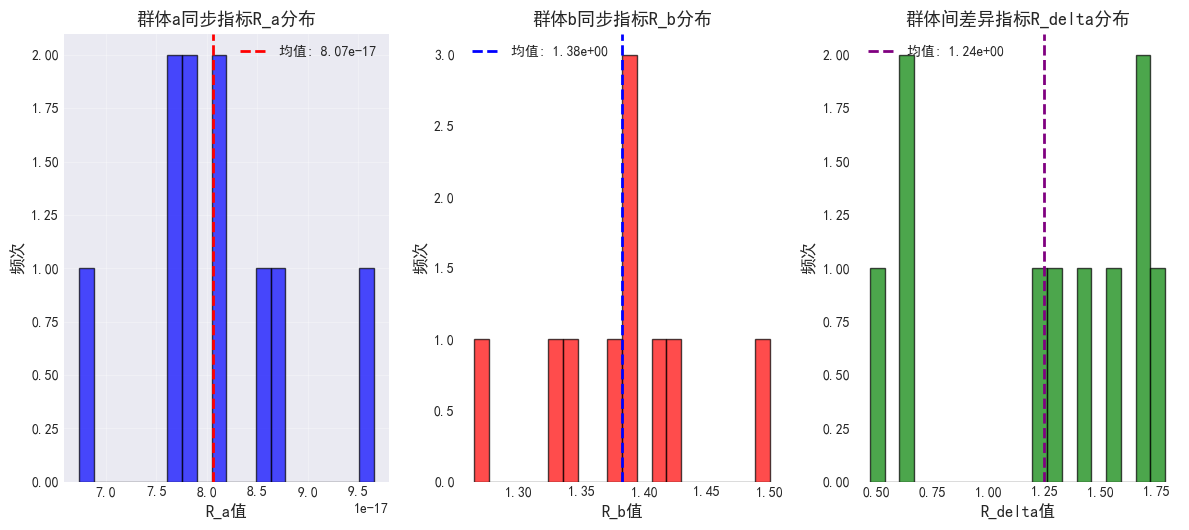

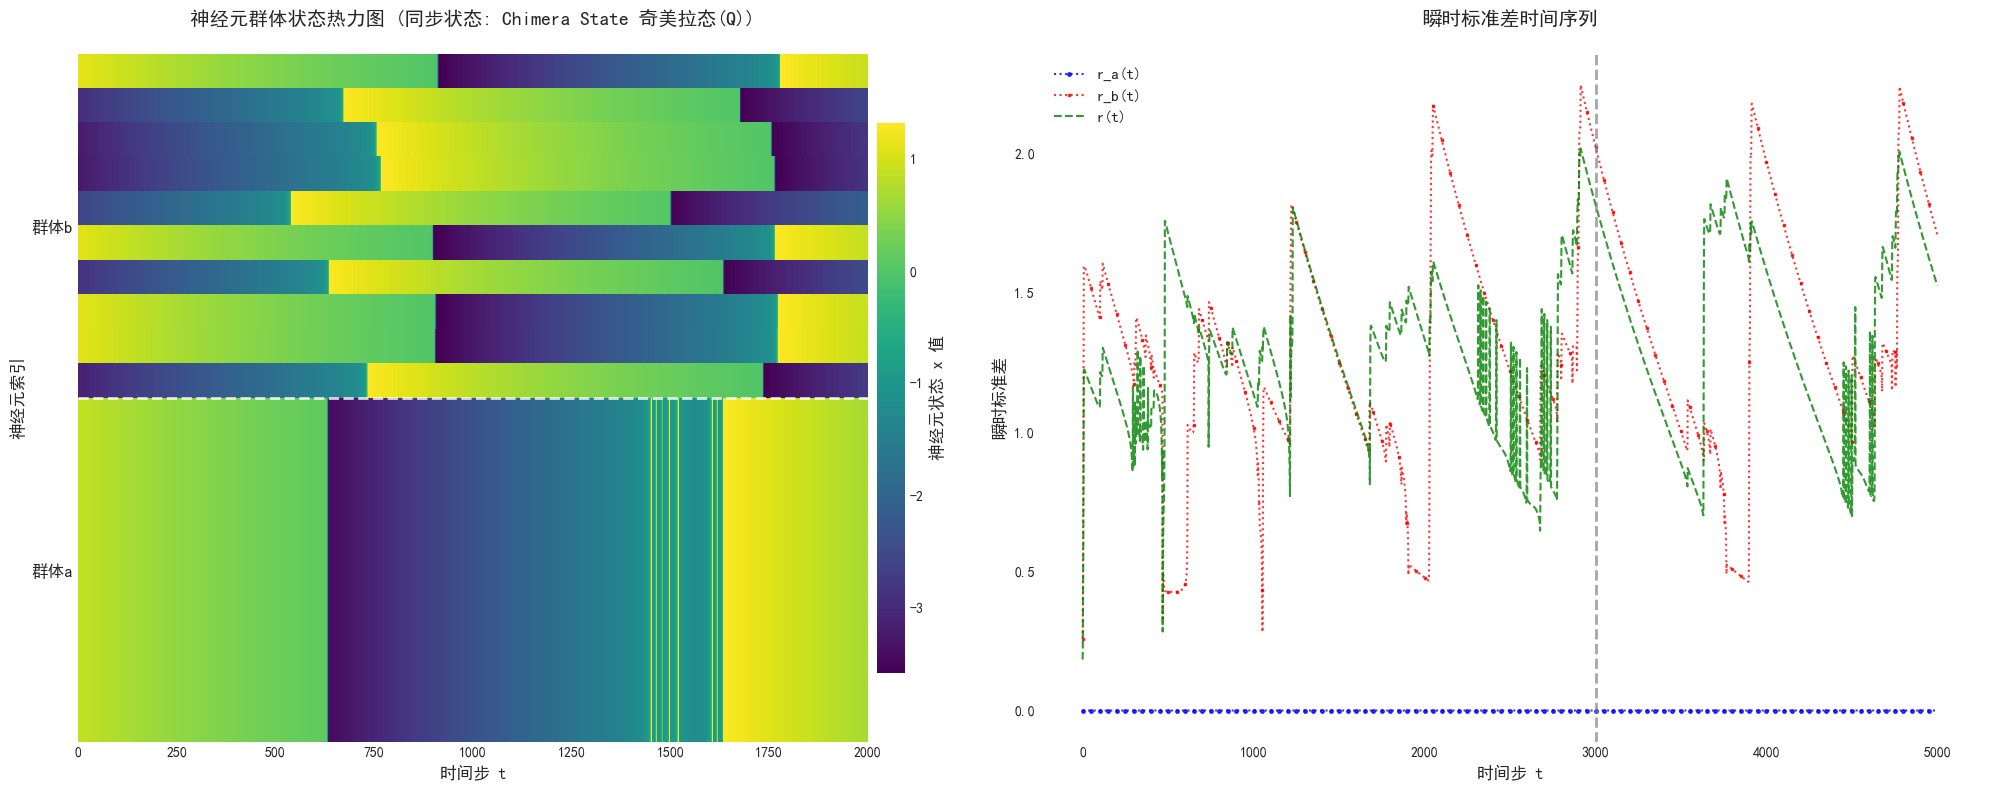

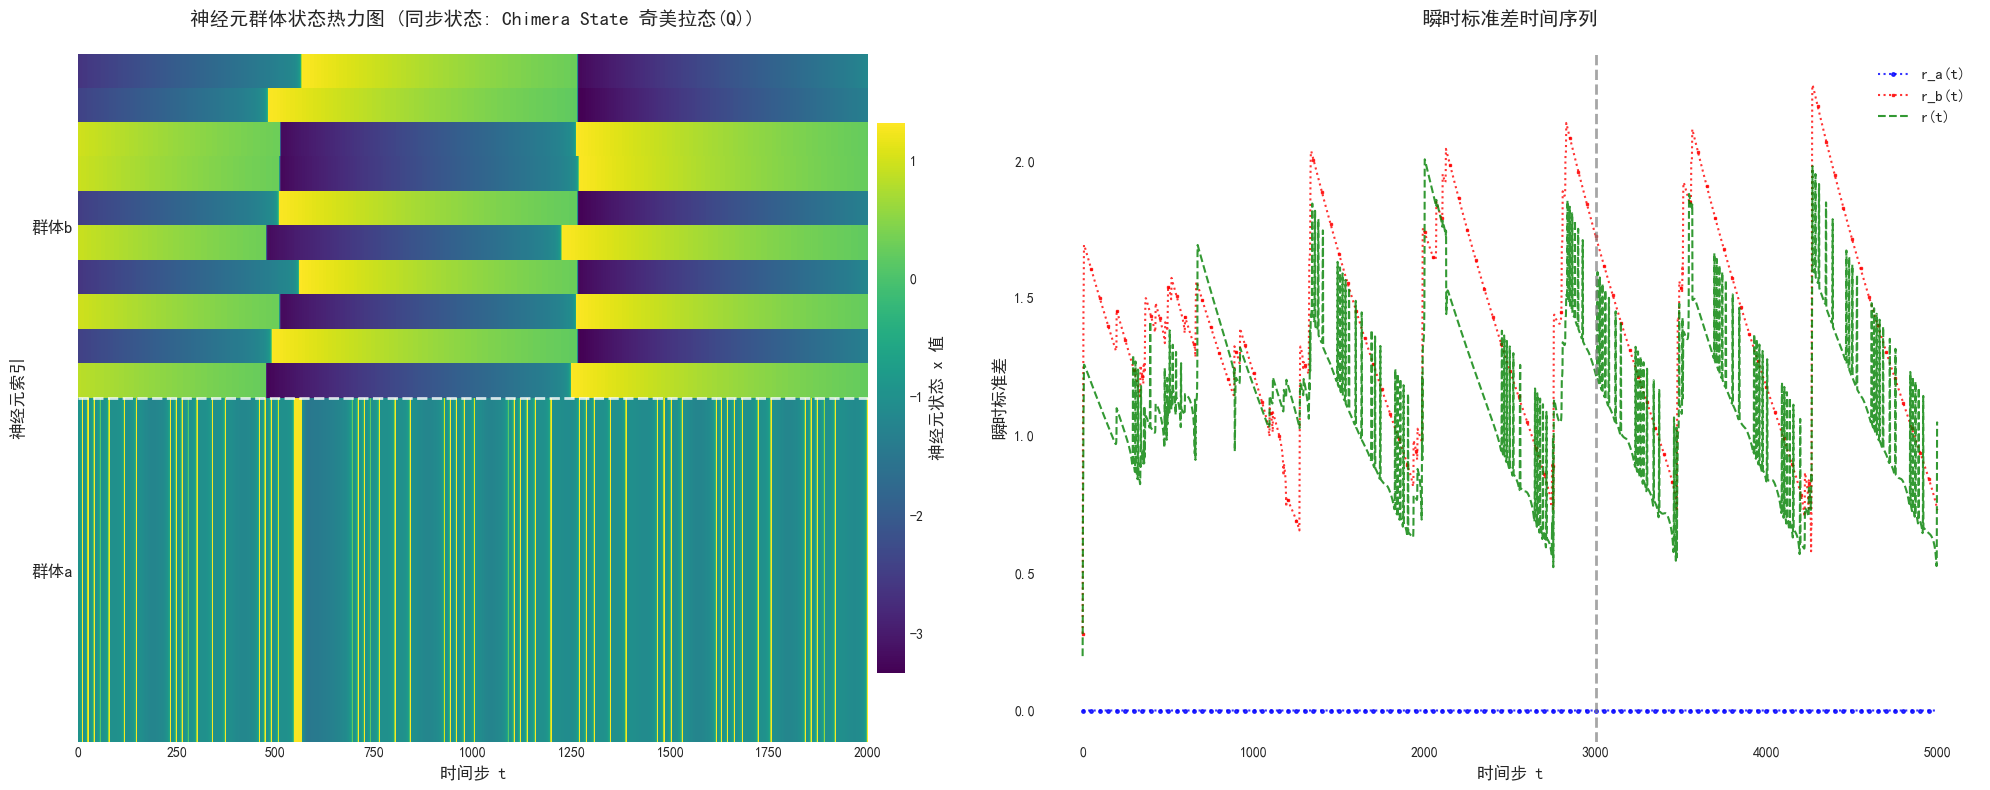

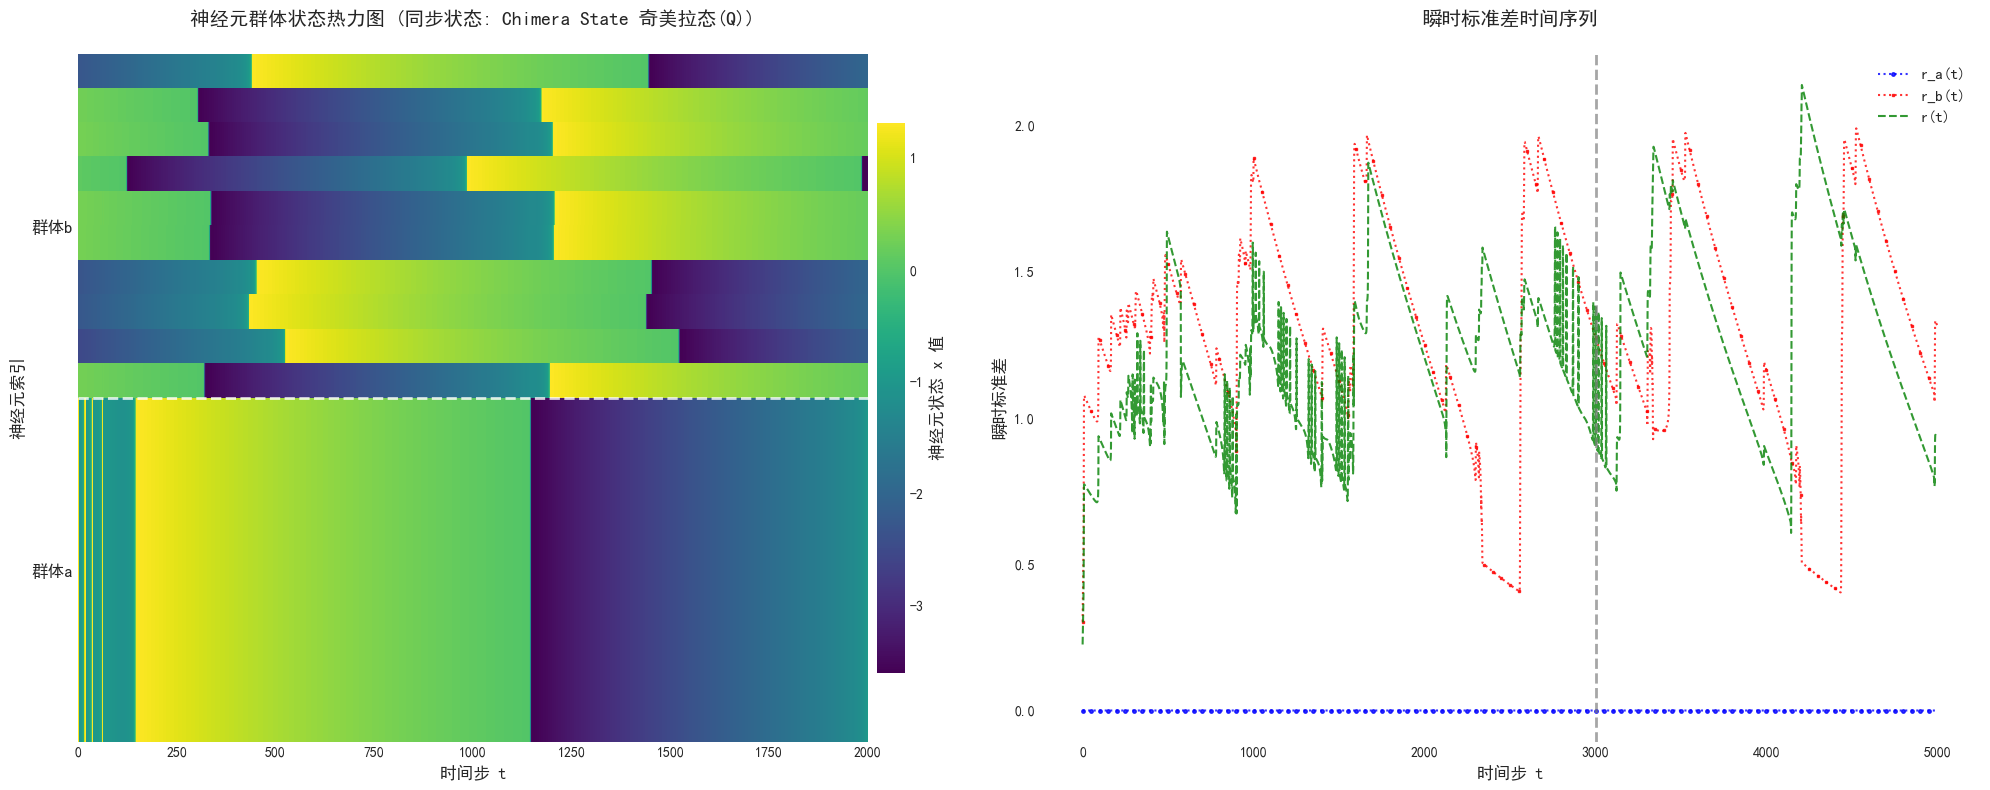

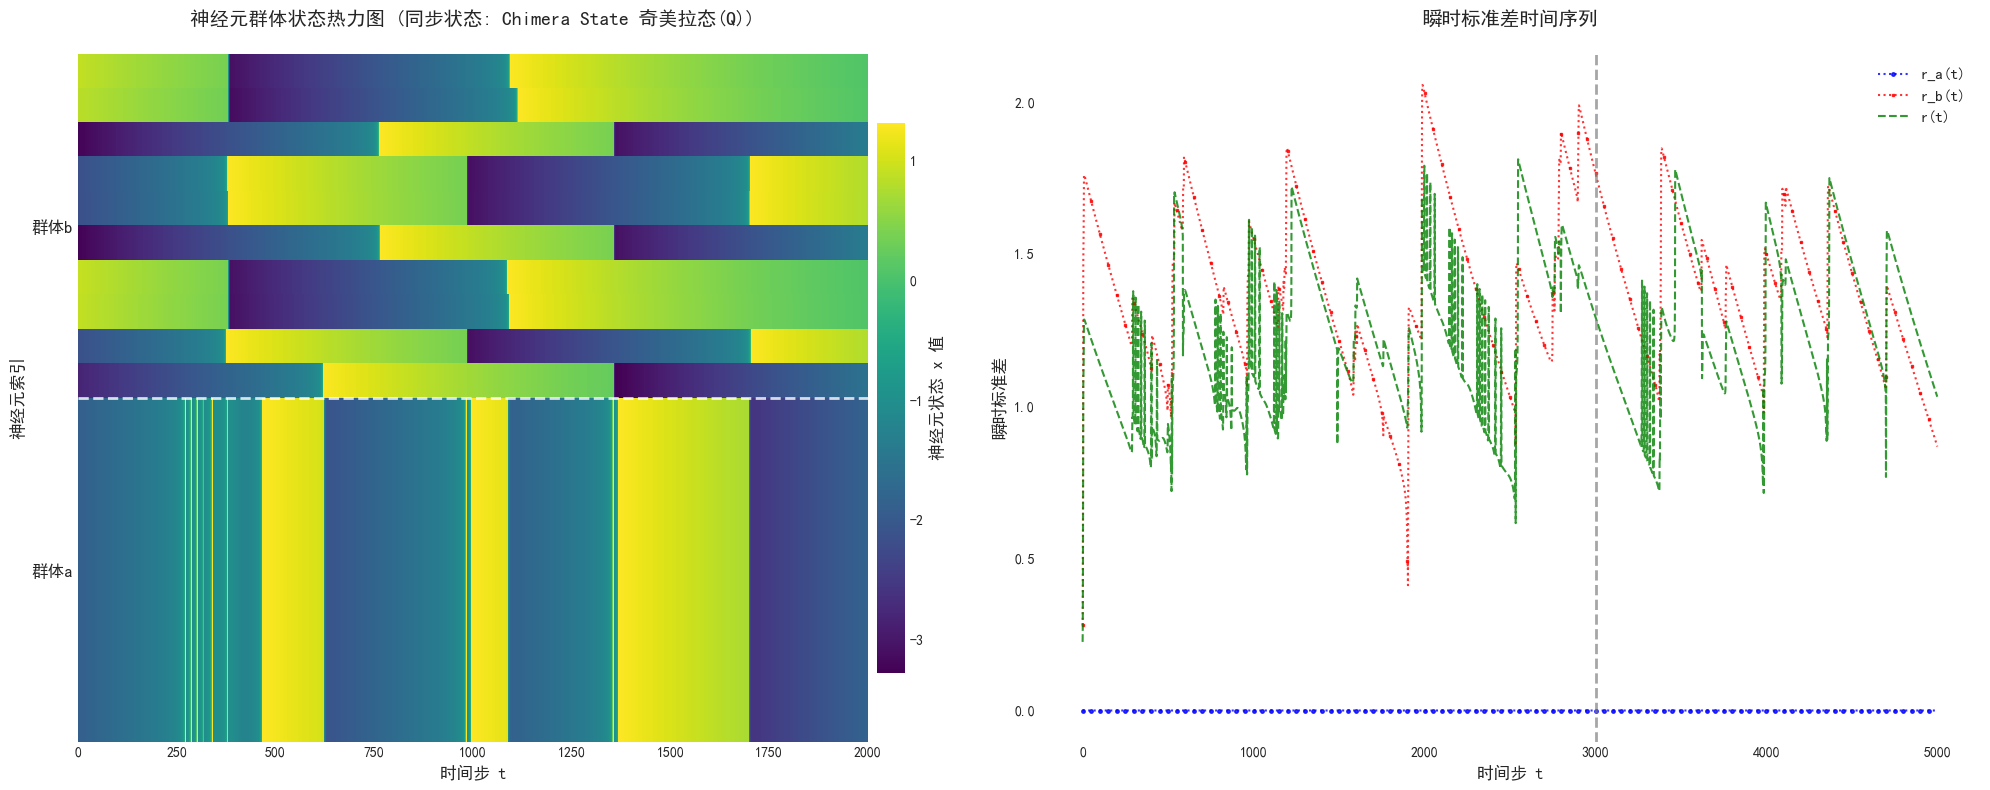

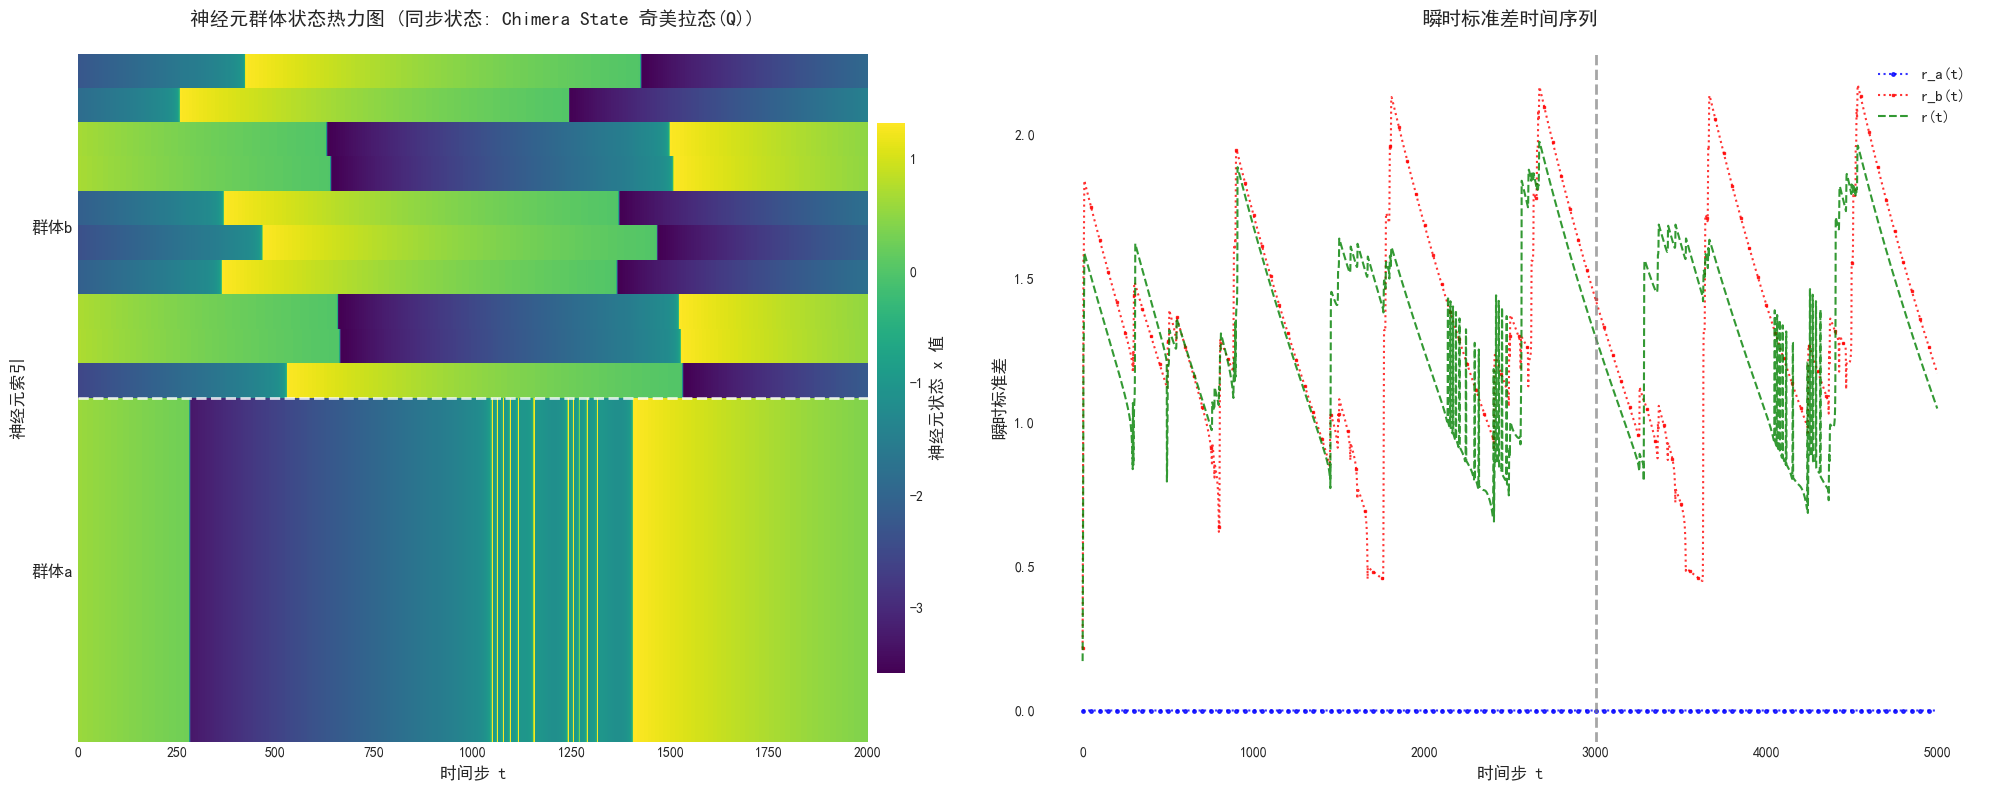

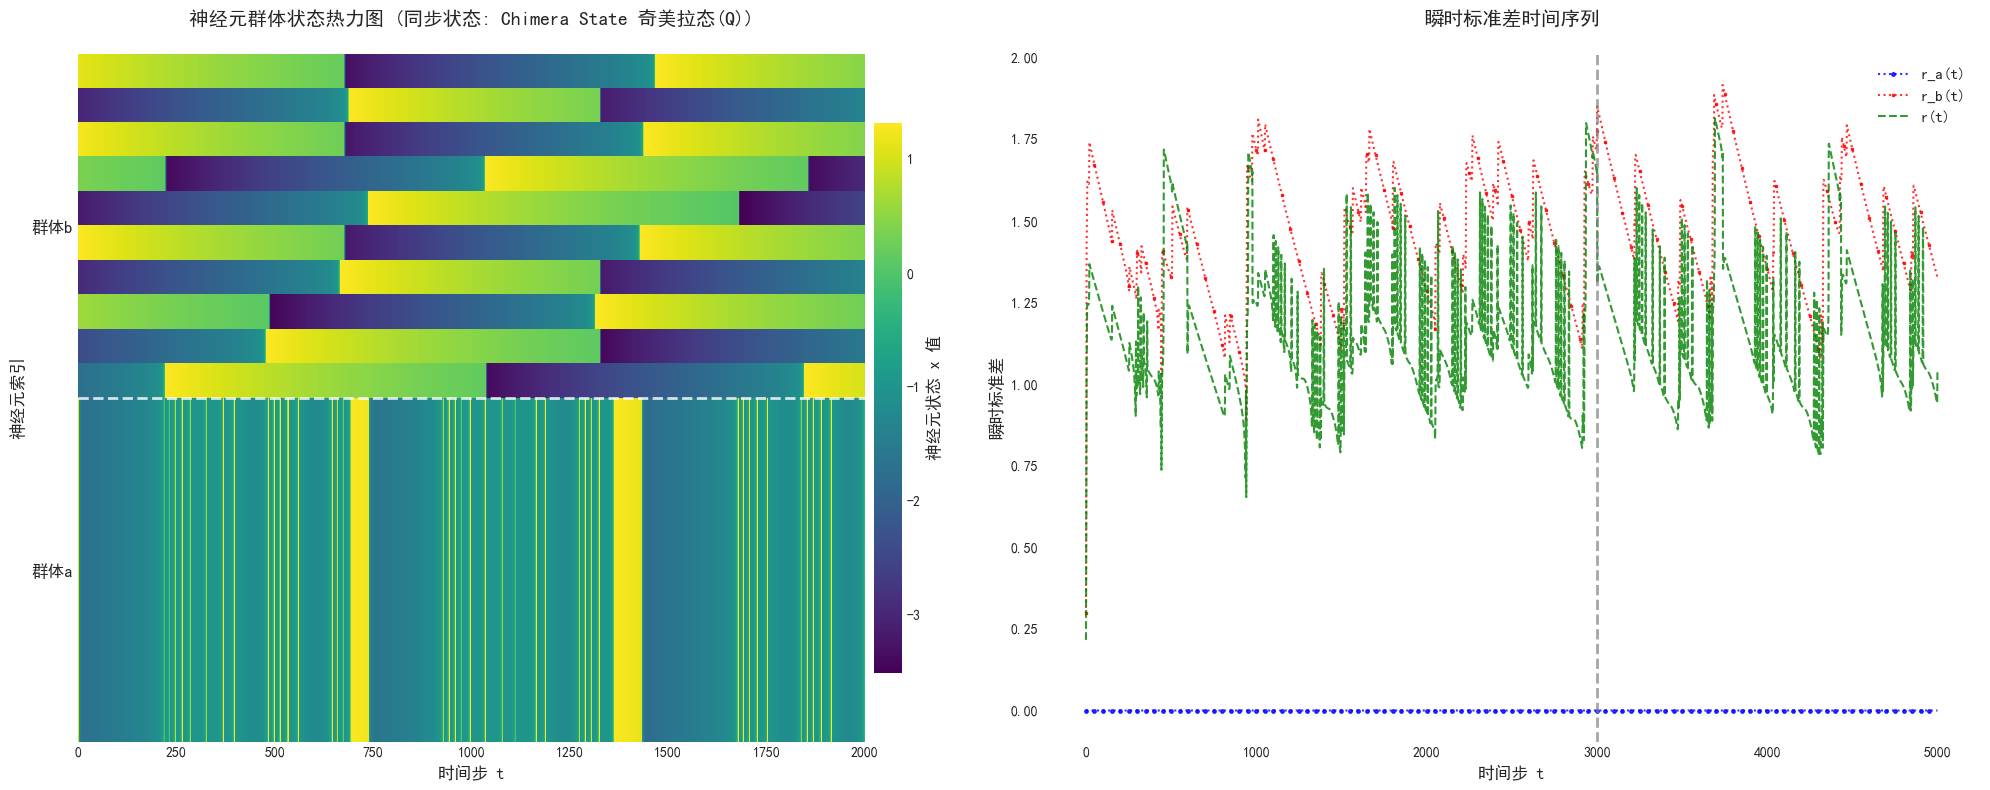

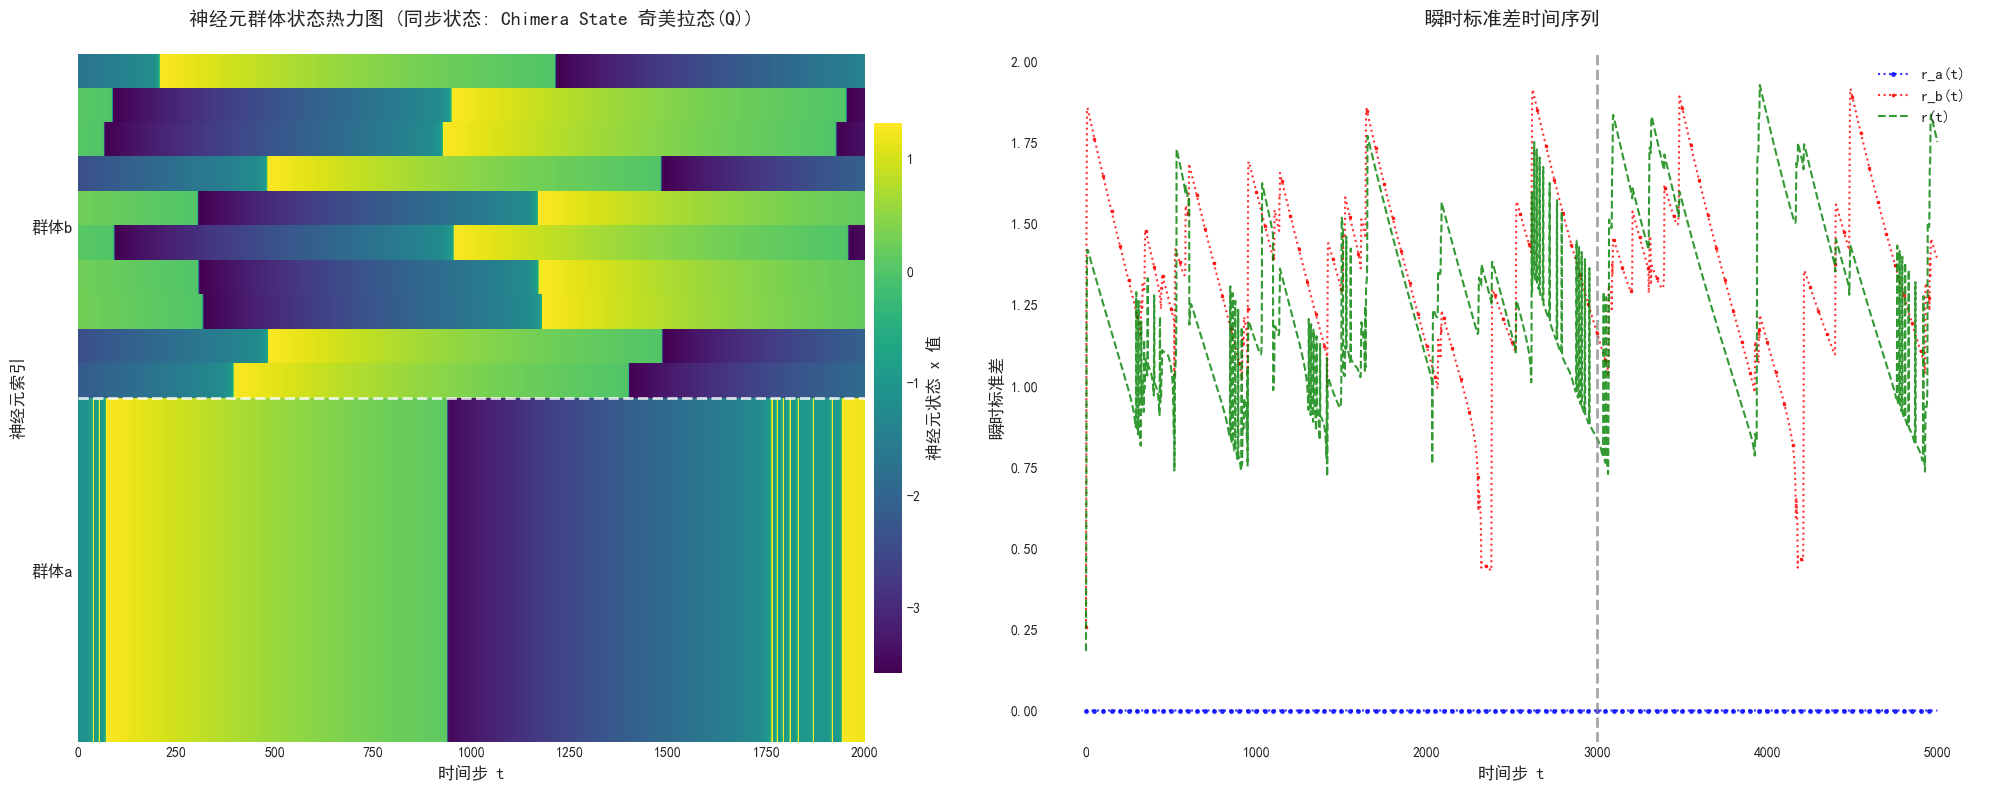

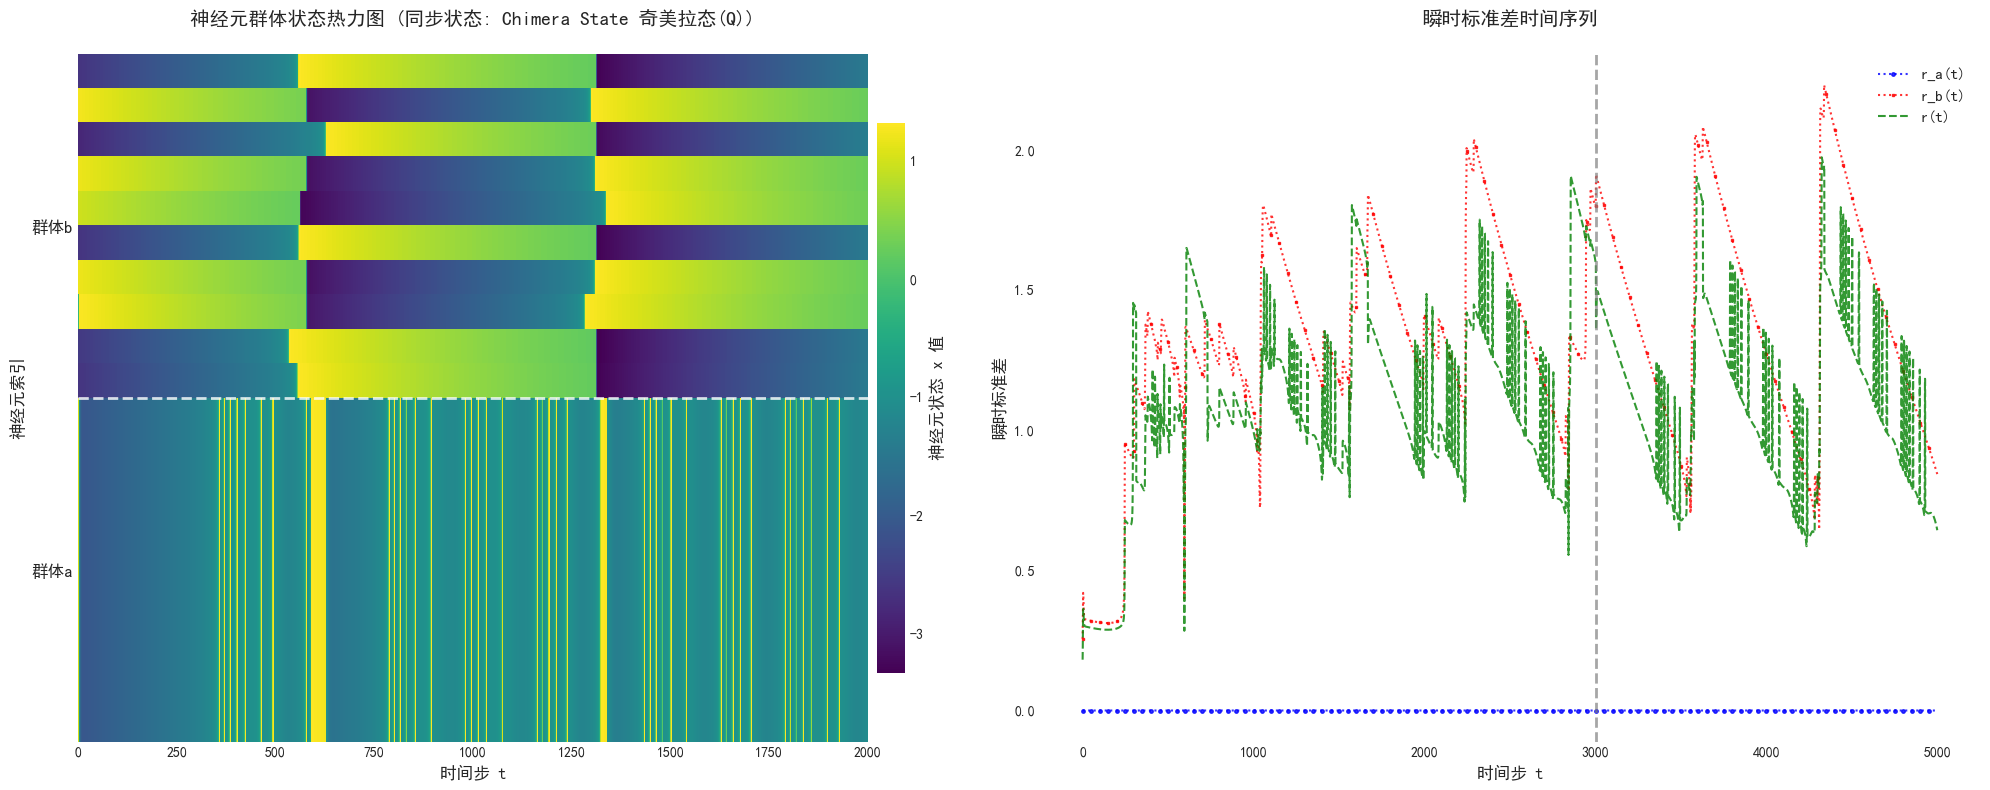

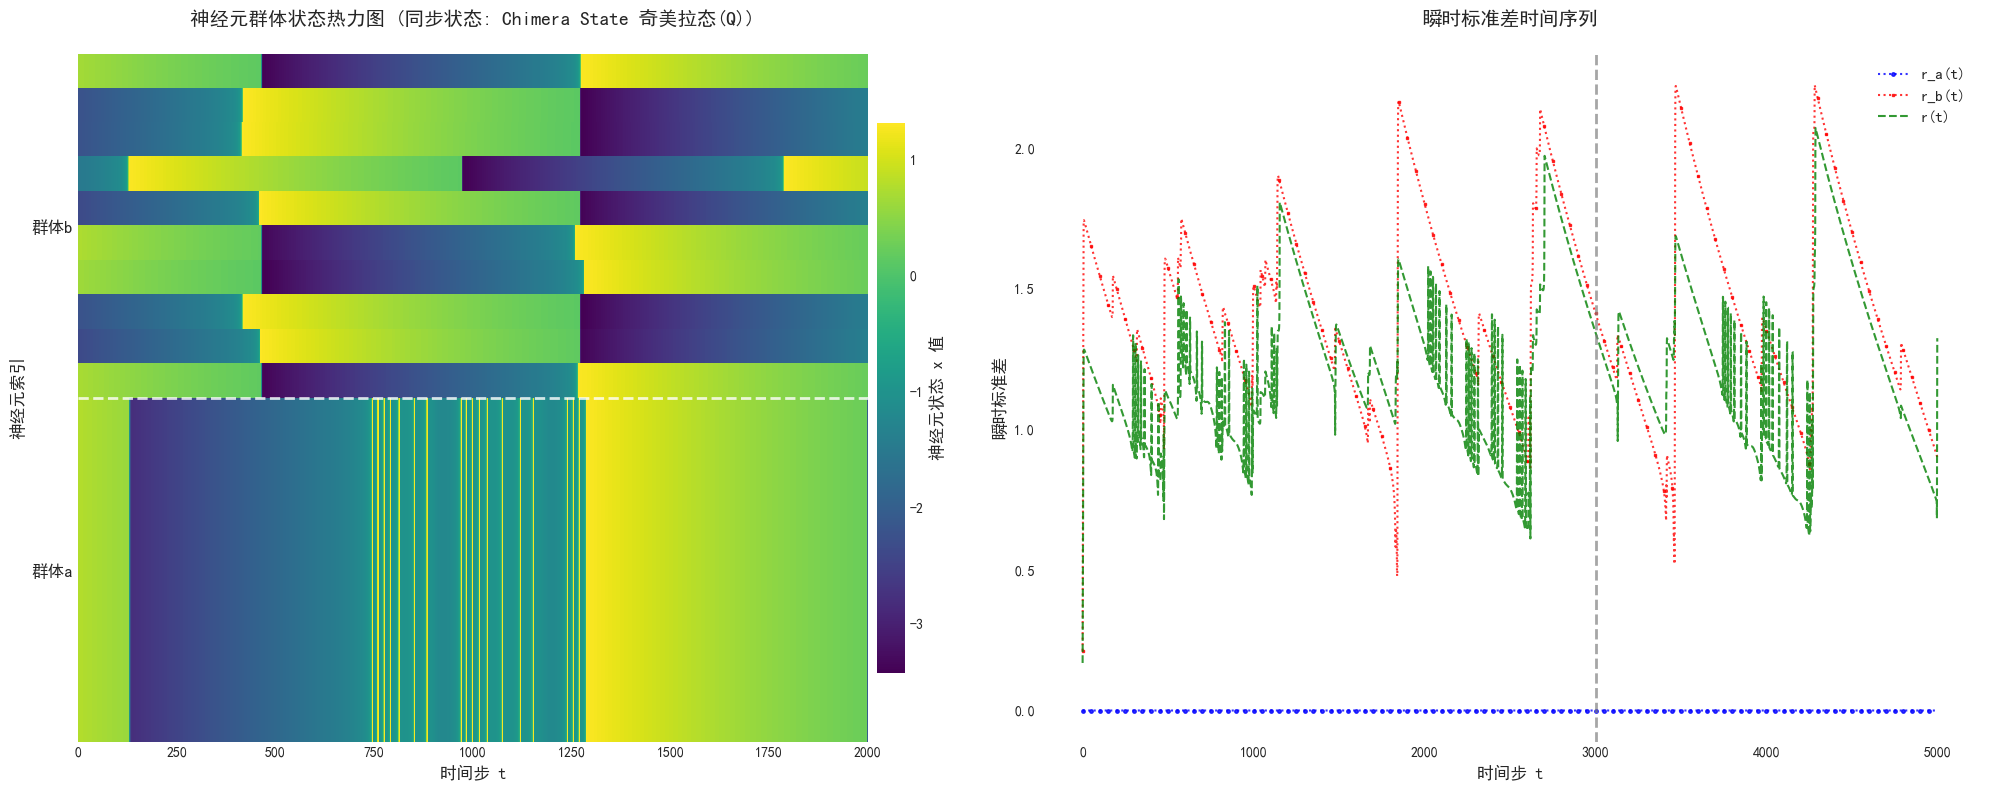

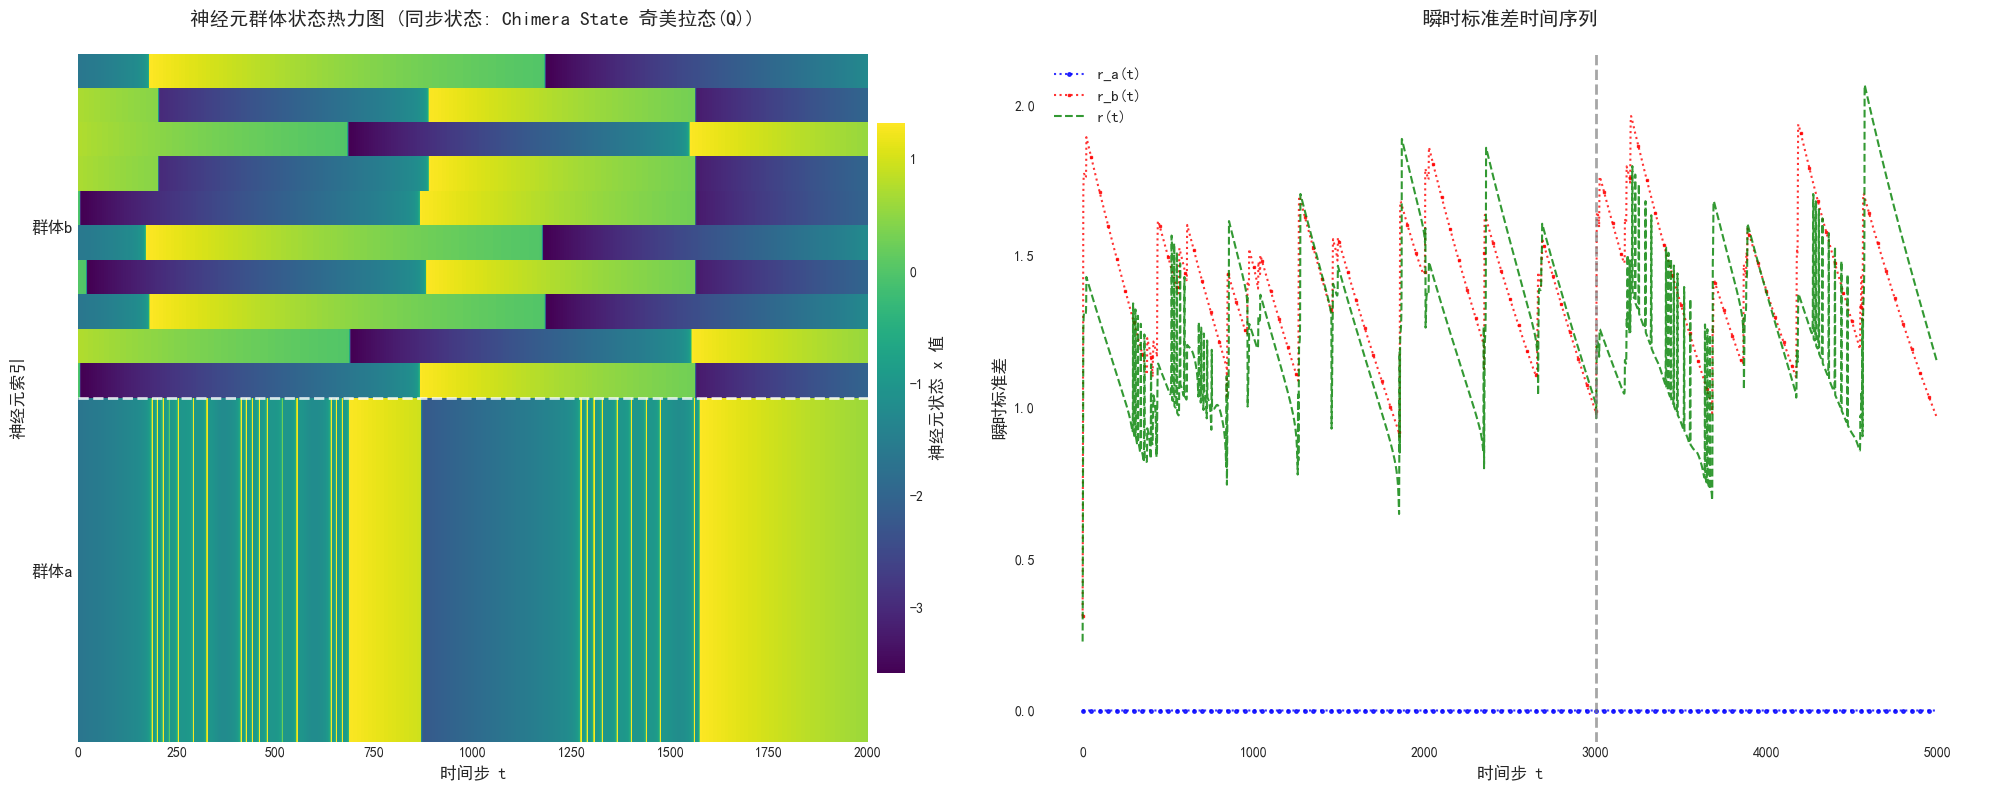


模拟完成！总共运行了 10 次模拟。


In [102]:
# 设置模拟参数
n = 10  # 模拟次数
n_a = 10
n_b = 10
x_data = []
t_list = []
simulation_results = []  # 存储所有模拟结果
statistics_list = []  # 存储统计信息

print(f"开始运行 {n} 次模拟...")

# 运行多次模拟
for i in range(n):
    # 使用不同的随机种子
    seed = i+103  
    
    print(f"运行模拟 {i+1}/{n} (种子: {seed})...", end=" ")
    
#     # 生成完全同步的CS数据
#     data = generate_two_population_neuron_data(
#         n_a=n_a, n_b=n_b,
#         alpha_a=4.6, alpha_b=4.6,
#         sigma_a=0.225, sigma_b=0.225,
#         mu=0.001, gamma=0.005, epsilon=0.002,
#         T=5000, transients=3000,  
#         seed=seed,x0_a=-1, x0_b=-1, y0_a=-3.5, y0_b=-3.5
#     )
#     # 生成广义同步的GS数据
#     data = generate_two_population_neuron_data(
#         n_a=n_a, n_b=n_b,
#         alpha_a=4.6, alpha_b=4.6,
#         sigma_a=0.225, sigma_b=0.225,
#         mu=0.001, gamma=0.005, epsilon=0.002,
#         T=5000, transients=3000,  
#         seed=seed,x0_a=-1, x0_b=-1.5, y0_a=-3.5, y0_b=-4
#     )
    # 生成奇美拉态的Q数据
    data = generate_two_population_neuron_data(
        n_a=n_a, n_b=n_b,
        alpha_a=4.6, alpha_b=4.6,
        sigma_a=0.225, sigma_b=0.225,
        mu=0.001, gamma=0.005, epsilon=0.002,
        T=5000, transients=3000,  
        seed=seed,x0_a=-1, x0_b=None, y0_a=-3.5, y0_b=None
    )
#     # 生成去同步化的D数据
#     data = generate_two_population_neuron_data(
#         n_a=n_a, n_b=n_b,
#         alpha_a=4.6, alpha_b=4.6,
#         sigma_a=0.225, sigma_b=0.225,
#         mu=0.001, gamma=0.005, epsilon=0.002,
#         T=5000, transients=3000,  
#         seed=seed,x0_a=None, x0_b=None, y0_a=None, y0_b=None
#     )
    
    cols = []
    for idx in range(1, n_a + 1):
        key = f'神经元_a_{idx:03d}'
        cols += [data[key]['x_transient'], data[key]['y_transient']]
    for idx in range(1, n_b + 1):
        key = f'神经元_b_{idx:03d}'
        cols += [data[key]['x_transient'], data[key]['y_transient']]
    
    x_train = np.column_stack(cols)  # shape: (时间步长, 特征数)
    t_train = data['时间序列']['t']
    x_data.append(x_train) 
    t_list.append(t_train)
    simulation_results.append(data)
    
    # 提取统计信息
    stats = {
        'seed': seed,
        'R_a': data['params']['⟨σa⟩ (R_a)'],
        'R_b': data['params']['⟨σb⟩ (R_b)'],
        'R_t': data['params']['⟨σt⟩ (R_t)'],
        'R_delta': data['params']['⟨δ⟩ (R_delta)'],
        'sync_state': data['params']['同步状态'],
        'sync_a': data['params']['a群体同步'],
        'sync_b': data['params']['b群体同步'],
        'sync_t': data['params']['Rt群体同步'],
        'sync_ab': data['params']['群体间同步']
    }
    statistics_list.append(stats)
    
    print(f"完成 - 同步状态: {stats['sync_state']}")
    print(f"R_a:{stats['R_a']:.6f}   R_b:{stats['R_b']:.6f}    R_t:{stats['R_t']:.6f}     R_delta:{stats['R_delta']:.6f}")

# 创建DataFrame用于分析
statistics_df = pd.DataFrame(statistics_list)

# 分析同步状态
analysis_results = analyze_sync_states(statistics_df)

# 绘制柱状图
plot_sync_statistics_histogram(statistics_df)

# 可视化
last_data = simulation_results[-1]
for i in range(n):
    plot_neuron_analysis_combo(simulation_results[i])
    # 单独绘制热力图
    #plot_neuron_state_heatmap(simulation_results[i])

print(f"\n模拟完成！总共运行了 {len(statistics_df)} 次模拟。")

# 选择library

In [103]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
#ode_lib = ps.PolynomialLibrary(degree=2,include_bias=True,interaction_only=True)# 只有交叉项
#ode_lib = ps.PolynomialLibrary(degree=2,include_bias=True,include_interaction=False,interaction_only=False)# 只有平方项
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False)# 都有
library_functions = [
    #lambda x: 1/(1-x),  
    lambda x_val, y_val, alpha: (
        alpha / (1 - x_val) + y_val if x_val <= 0 
        else (alpha + y_val if 0 < x_val < alpha + y_val 
              else -1)
    )
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ode_lib

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 检查观测函数变量名
print(len(names))
#print(names)

860


# 进行拟合

In [104]:
# 离散的迭代方程 or 连续的微分方程
#discrete_time=False
discrete_time=True
dt = 1
# 候选拟合器
lasso_optimizer = Lasso(alpha=0.01, max_iter=2000, fit_intercept=False)
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l1") # score为负
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=1e-5, normalize_columns=True)
ssr_optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
ridge_optimizer = Ridge(alpha=1.0,max_iter=2000,fit_intercept=False,tol=1e-3,solver="auto")
elastic_net = ElasticNet(
    alpha=0.01,          # 总正则化强度（alpha = l1_ratio*L1 + (1-l1_ratio)*L2）
    l1_ratio=0.5,        # L1占比：0.5表示L1和L2各占50%；1=纯Lasso，0=纯Ridge
    max_iter=2000,
    fit_intercept=False,
    tol=1e-4
)
optimizer = stlsq_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
#model.print()

MemoryError: Unable to allocate 5.64 MiB for an array with shape (860, 860) and data type float64

In [ ]:
# 计算score
model.score(x_data_lift, t=dt)

# 多步预测

In [18]:
# 单时间序列
#init_data = x_data_lift[0,:]
# 多时间序列
init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,len(t_list[0]))
else:
    X_data_predicted = model.simulate(init_data,t_list[0]) 

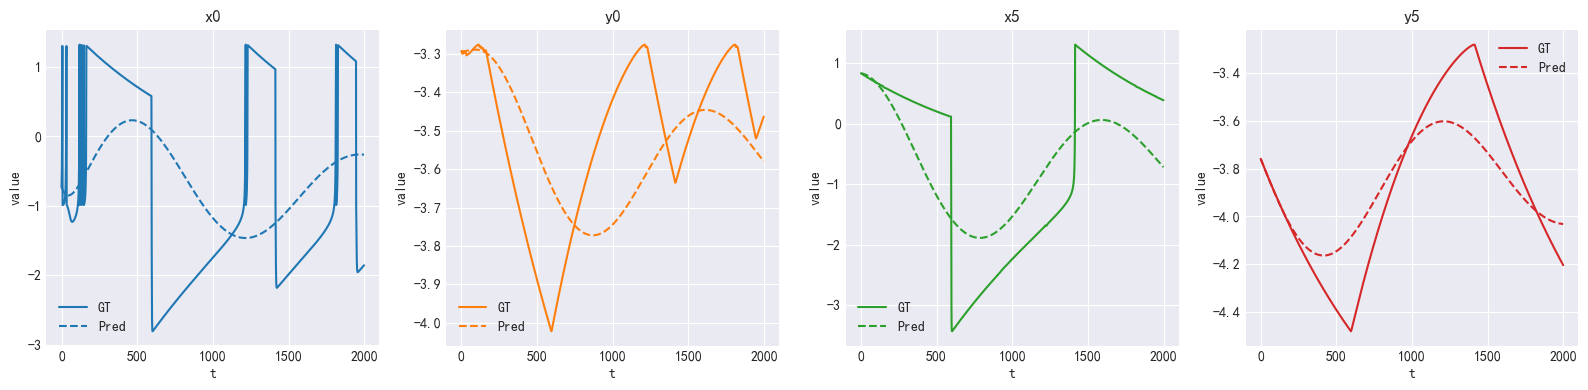

In [19]:
plot_idx = [0, 1, 10, 11]        

channels = ['x0', 'y0', 'x5', 'y5'] 

colors = plt.cm.tab10.colors[:len(plot_idx)]

fig, axes = plt.subplots(1, len(plot_idx),
                         figsize=(4*len(plot_idx), 4),
                         sharex=True, sharey=False)
axes = np.atleast_1d(axes)

for ax, idx, name, c in zip(axes, plot_idx, channels, colors):
    # 真实值
    ax.plot(x_data_lift[0][:, idx], ls='-', c=c, label='GT')
    # 预测值
    ax.plot(X_data_predicted[:, idx], ls='--', c=c, label='Pred')

    ax.set_title(name)
    ax.set_xlabel('t')
    ax.set_ylabel('value')
    ax.legend()

plt.tight_layout()
plt.show()

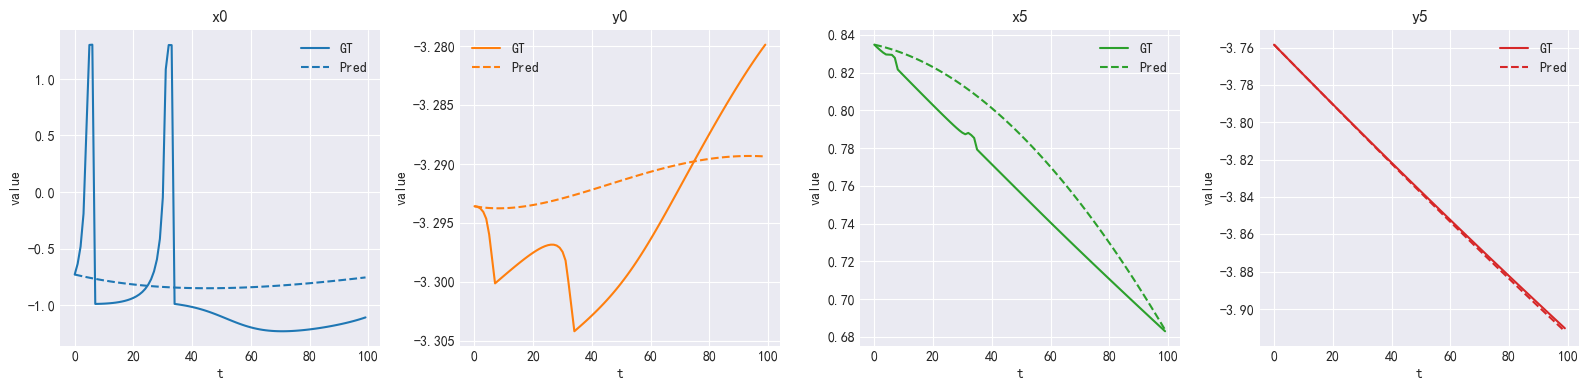

In [20]:
plot_idx = [0, 1, 10, 11]        

channels = ['x0', 'y0', 'x5', 'y5'] 

colors = plt.cm.tab10.colors[:len(plot_idx)]

fig, axes = plt.subplots(1, len(plot_idx),
                         figsize=(4*len(plot_idx), 4),
                         sharex=True, sharey=False)
axes = np.atleast_1d(axes)

for ax, idx, name, c in zip(axes, plot_idx, channels, colors):
    # 真实值
    ax.plot(x_data_lift[0][:100, idx], ls='-', c=c, label='GT')
    # 预测值
    ax.plot(X_data_predicted[:100, idx], ls='--', c=c, label='Pred')

    ax.set_title(name)
    ax.set_xlabel('t')
    ax.set_ylabel('value')
    ax.legend()

plt.tight_layout()
plt.show()

# svd分解

In [ ]:
# 提取和处理系数矩阵
A = model.coefficients()
print(A.shape)
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(5, 4)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

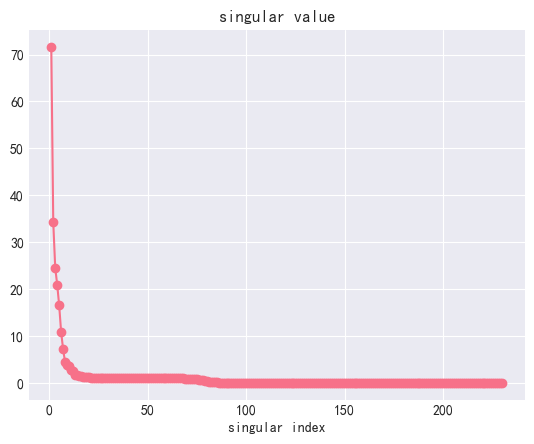

[7.16591007e+01 3.42592163e+01 2.45404044e+01 2.09452243e+01
 1.65507703e+01 1.08305567e+01 7.17690802e+00 4.42157658e+00
 3.81036049e+00 3.65837602e+00 2.80193999e+00 2.43415181e+00
 1.74696500e+00 1.57531892e+00 1.45674032e+00 1.35286911e+00
 1.22744280e+00 1.19362283e+00 1.15091906e+00 1.12780636e+00
 1.10805363e+00 1.09785583e+00 1.06342941e+00 1.05329980e+00
 1.04981858e+00 1.04106689e+00 1.03512568e+00 1.02882343e+00
 1.02214794e+00 1.02049654e+00 1.01837592e+00 1.01642749e+00
 1.01318648e+00 1.01092310e+00 1.01073209e+00 1.00934695e+00
 1.00466774e+00 1.00416134e+00 1.00245426e+00 1.00164998e+00
 1.00057259e+00 1.00032840e+00 1.00022066e+00 1.00010077e+00
 1.00000100e+00 9.99942897e-01 9.99428689e-01 9.98663172e-01
 9.97787352e-01 9.96752468e-01 9.95400440e-01 9.94400436e-01
 9.92583610e-01 9.90077093e-01 9.88984211e-01 9.88700502e-01
 9.85059255e-01 9.83547336e-01 9.80873178e-01 9.74768059e-01
 9.70824307e-01 9.64761397e-01 9.61312864e-01 9.55376558e-01
 9.52132203e-01 9.447649

In [97]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(range(1,len(S)+1), S, marker='o')
# plt.semilogy(range(1, len(S)+1), S, marker='o')   # 对数坐标轴
plt.grid(True)
plt.xlabel('singular index')
plt.title('singular value')
plt.show()
print(S)

In [ ]:
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')          # 只留横网格，看起来更干净
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

In [ ]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [ ]:
# 计算EC
print(compute_entropy(diff))

In [101]:
import pickle
with open("diffQ5.pkl", "wb") as f:
    pickle.dump(diff, f)

In [24]:
# 选取截断
rank = 8
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.33254587454984563


# 输出粗粒化表达式

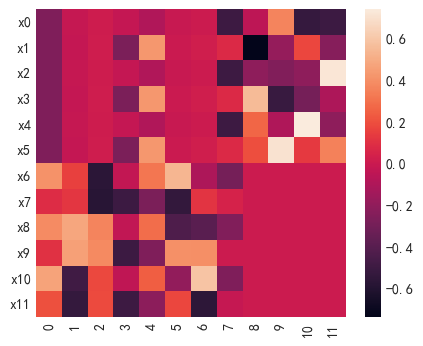

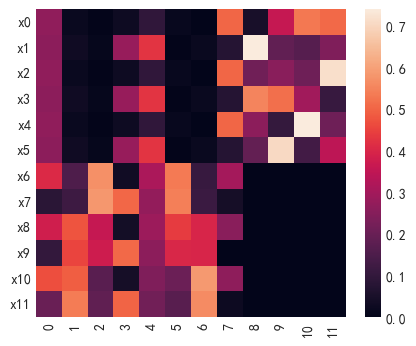

In [27]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

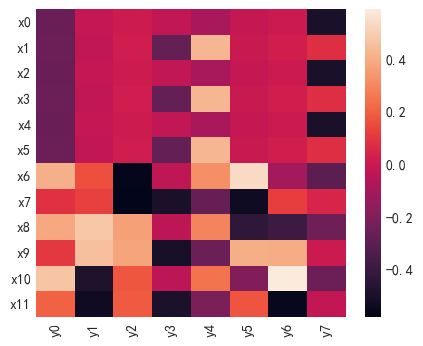

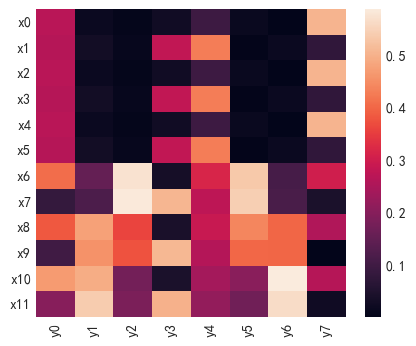

In [28]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [29]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = -0.2659 * x0 - 0.2611 * x1 - 0.2659 * x2 - 0.2611 * x3 - 0.2659 * x4 - 0.2611 * x5 + 0.4054 * x6 + 0.0809 * x7 + 0.3811 * x8 + 0.0995 * x9 + 0.4663 * x10 + 0.1997 * x11
------------------------------
y1 = -0.0182 * x0 - 0.0294 * x1 - 0.0182 * x2 - 0.0294 * x3 - 0.0182 * x4 - 0.0294 * x5 + 0.1528 * x6 + 0.1188 * x7 + 0.4758 * x8 + 0.4533 * x9 - 0.4902 * x10 - 0.5356 * x11
------------------------------
y2 = 0.0052 * x0 + 0.0110 * x1 + 0.0052 * x2 + 0.0110 * x3 + 0.0052 * x4 + 0.0110 * x5 - 0.5709 * x6 - 0.5833 * x7 + 0.3589 * x8 + 0.3754 * x9 + 0.1727 * x10 + 0.1839 * x11
------------------------------
y3 = -0.0270 * x0 - 0.2776 * x1 - 0.0270 * x2 - 0.2776 * x3 - 0.0270 * x4 - 0.2776 * x5 - 0.0325 * x6 - 0.5055 * x7 - 0.0393 * x8 - 0.5079 * x9 - 0.0426 * x10 - 0.4987 * x11
------------------------------
y4 = -0.0953 * x0 + 0.4258 * x1 - 0.0953 * x2 + 0.4258 * x3 - 0.0953 * x4 + 0.4258 * x5 + 0.3146 * x6 - 0.2743 * x7 + 0.2878 * x8 - 0.2609 * x9 + 0.2391 * x10 - 0.2156 * x11
-------

# 描述宏观演化

In [30]:
macro_data = x_data_lift[0] @ coarse_grain_coff
macro_dim = macro_data.shape[1]

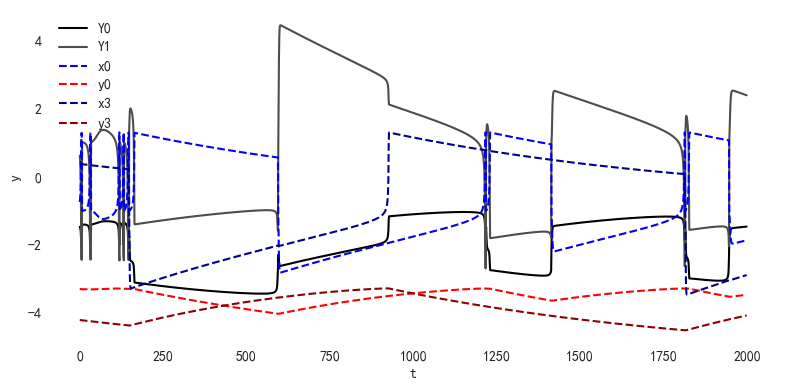

In [42]:
# 原始数据
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(macro_data[:,4], color='0', label='Y0')  
ax.plot(macro_data[:,7], color='0.3', label='Y1')
#ax.plot(macro_data[:,2], color='0.5', label='Y2')  
#ax.plot(macro_data[:,3], color='0.8', label='Y3')
ax.plot(x_data[0][:,0], '--',color='blue', label='x0')
ax.plot(x_data[0][:,1], '--',color='red', label='y0')
ax.plot(x_data[0][:,6], '--',color='darkblue', label='x3')
ax.plot(x_data[0][:,7], '--',color='darkred', label='y3')
ax.legend()
ax.set(xlabel='t', ylabel='y')
ax.set_facecolor('white')  
ax.grid(False)
fig.tight_layout()
plt.show()

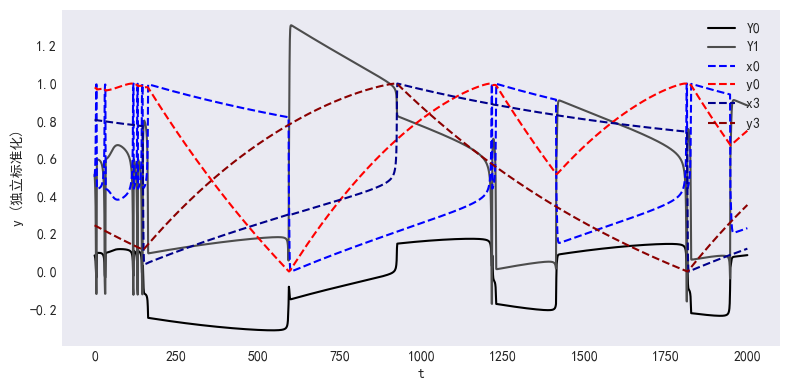

In [43]:
# 各自标准化到0-1
fig, ax = plt.subplots(figsize=(8, 4))

# 独立标准化每条曲线
ax.plot((macro_data[:,4] - macro_data[:,0].min()) / (macro_data[:,0].max() - macro_data[:,0].min()), 
        color='0', label='Y0')
ax.plot((macro_data[:,7] - macro_data[:,1].min()) / (macro_data[:,1].max() - macro_data[:,1].min()), 
        color='0.3', label='Y1')
#ax.plot((macro_data[:,2] - macro_data[:,2].min()) / (macro_data[:,2].max() - macro_data[:,2].min()), 
#        color='0.5', label='Y2')
#ax.plot((macro_data[:,3] - macro_data[:,3].min()) / (macro_data[:,3].max() - macro_data[:,3].min()), 
#        color='0.8', label='Y3')

# 标准化x_data的每条曲线
#, (20, 'darkblue', 'x10'), (21, 'darkred', 'y10')
for i, (idx, color, name) in enumerate([(0, 'blue', 'x0'), (1, 'red', 'y0'), (6, 'darkblue', 'x3'), (7, 'darkred', 'y3')]):
    data = x_data[0][:, idx]
    data_min, data_max = data.min(), data.max()
    if data_max == data_min:
        normalized_data = np.ones_like(data) * 0.5
    else:
        normalized_data = (data - data_min) / (data_max - data_min)
    ax.plot(normalized_data, '--', color=color, label=f'{name} ')

ax.legend()
ax.set(xlabel='t', ylabel='y (独立标准化)')
ax.grid(False)
fig.tight_layout()
plt.show()

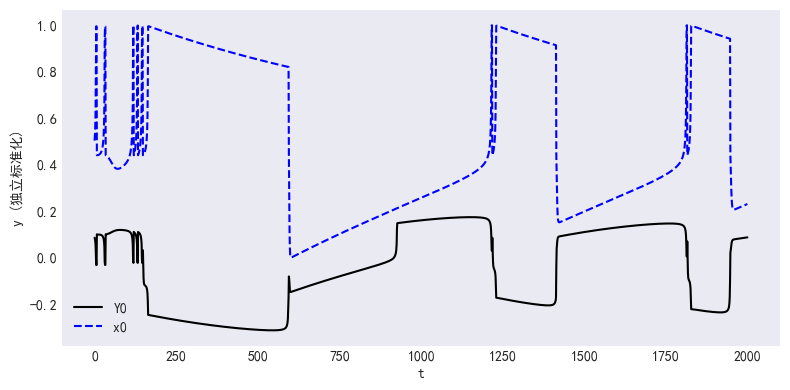

In [45]:
# 各自标准化到0-1
fig, ax = plt.subplots(figsize=(8, 4))

# 独立标准化每条曲线
ax.plot((macro_data[:,4] - macro_data[:,0].min()) / (macro_data[:,0].max() - macro_data[:,0].min()), 
        color='0', label='Y0')

# 标准化x_data的每条曲线
#, (20, 'darkblue', 'x10'), (21, 'darkred', 'y10')
for i, (idx, color, name) in enumerate([(0, 'blue', 'x0')]):
    data = x_data[0][:, idx]
    data_min, data_max = data.min(), data.max()
    if data_max == data_min:
        normalized_data = np.ones_like(data) * 0.5
    else:
        normalized_data = (data - data_min) / (data_max - data_min)
    ax.plot(normalized_data, '--', color=color, label=f'{name} ')

ax.legend()
ax.set(xlabel='t', ylabel='y (独立标准化)')
ax.grid(False)
fig.tight_layout()
plt.show()

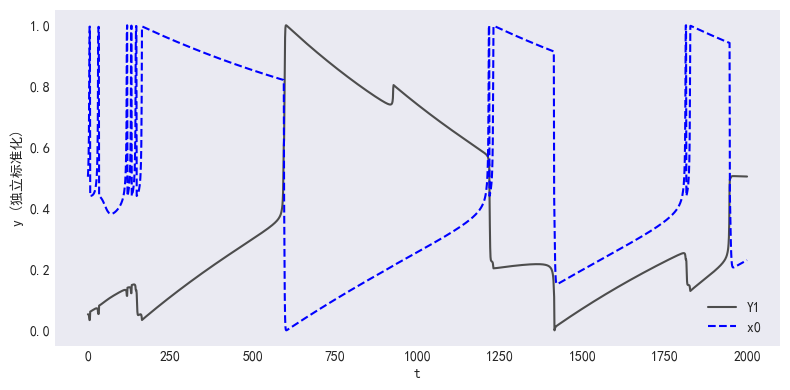

In [35]:
# 各自标准化到0-1
fig, ax = plt.subplots(figsize=(8, 4))

# 独立标准化每条曲线
ax.plot((macro_data[:,1] - macro_data[:,1].min()) / (macro_data[:,1].max() - macro_data[:,1].min()), 
        color='0.3', label='Y1')
for i, (idx, color, name) in enumerate([(0, 'blue', 'x0')]):
    data = x_data[0][:, idx]
    data_min, data_max = data.min(), data.max()
    if data_max == data_min:
        normalized_data = np.ones_like(data) * 0.5
    else:
        normalized_data = (data - data_min) / (data_max - data_min)
    ax.plot(normalized_data, '--', color=color, label=f'{name} ')

ax.legend()
ax.set(xlabel='t', ylabel='y (独立标准化)')
ax.grid(False)
fig.tight_layout()
plt.show()

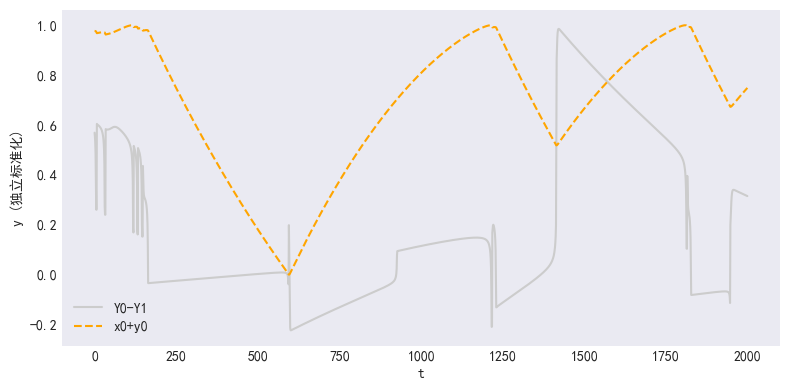

In [36]:
# 标准化后+-
fig, ax = plt.subplots(figsize=(8, 4))
Y0=(macro_data[:,0] - macro_data[:,0].min()) / (macro_data[:,0].max() - macro_data[:,0].min())
Y1=(macro_data[:,1] - macro_data[:,1].min()) / (macro_data[:,1].max() - macro_data[:,1].min())
x0=(x_data[0][:,0] - x_data[0][:,0].min()) / (x_data[0][:,0].max() - x_data[0][:,0].min())
y0=(x_data[0][:,1] - x_data[0][:,1].min()) / (x_data[0][:,1].max() - x_data[0][:,1].min())
#ax.plot(Y0+Y1,color='0.3', label='Y0+Y1')
ax.plot(Y0-Y1,color='0.8', label='Y0-Y1')
ax.plot(y0, '--', color='orange', label='x0+y0')
#ax.plot(x0-y0, '--', color='red', label='x0-y0')
ax.legend()
ax.set(xlabel='t', ylabel='y (独立标准化)')
ax.grid(False)
fig.tight_layout()
plt.show()

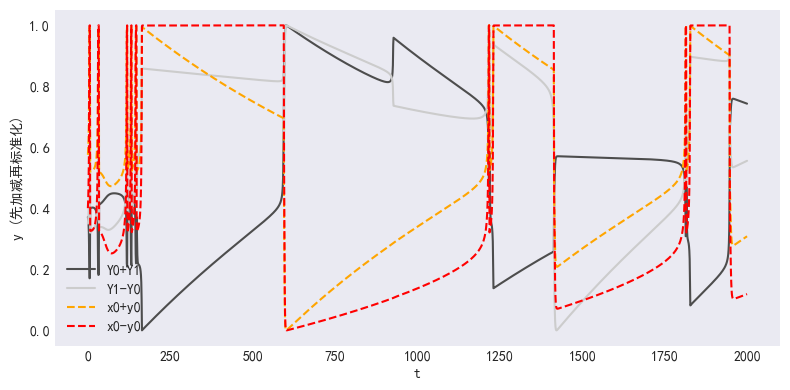

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))

sum_raw_01 = macro_data[:, 0] + macro_data[:, 1]   # Y0+Y1
dif_raw_01 = macro_data[:, 1] - macro_data[:, 0]   # Y1-Y0

sum_raw_xy = x_data[0][:, 0] + x_data[0][:, 1]     # x0+y0
dif_raw_xy = x_data[0][:, 0] - x_data[0][:, 1]     # x0-y0

def minmax(a):
    return (a - a.min()) / (a.max() - a.min())

Y0_plus_Y1 = minmax(sum_raw_01)
Y1_minus_Y0 = minmax(dif_raw_01)
x0_plus_y0 = minmax(sum_raw_xy)
x0_minus_y0 = minmax(dif_raw_xy)

ax.plot(Y0_plus_Y1, color='0.3', label='Y0+Y1')
ax.plot(Y1_minus_Y0, color='0.8', label='Y1-Y0')
ax.plot(x0_plus_y0, '--', color='orange', label='x0+y0')
ax.plot(x0_minus_y0, '--', color='red', label='x0-y0')

ax.legend()
ax.set(xlabel='t', ylabel='y (先加减再标准化)')
ax.grid(False)
fig.tight_layout()
plt.show()

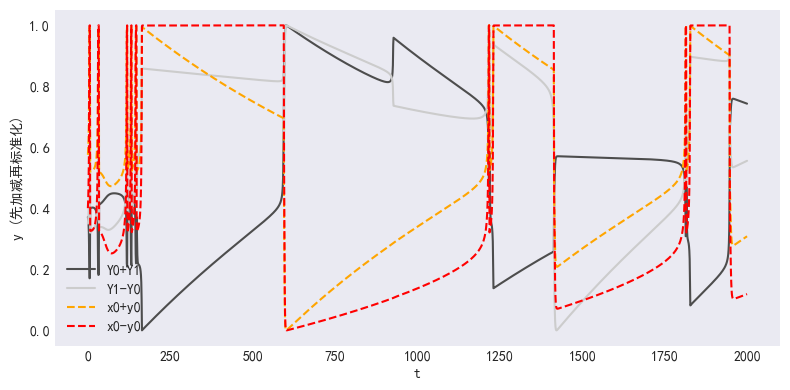

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))

sum_raw_01 = macro_data[:, 0] + macro_data[:, 1]   # Y0+Y1
dif_raw_01 = macro_data[:, 1] - macro_data[:, 0]   # Y1-Y0

sum_raw_xy = x_data[0][:, 0] + x_data[0][:, 1]     # x0+y0
dif_raw_xy = x_data[0][:, 0] - x_data[0][:, 1]     # x0-y0

def minmax(a):
    return (a - a.min()) / (a.max() - a.min())

Y0_plus_Y1 = minmax(sum_raw_01)
Y1_minus_Y0 = minmax(dif_raw_01)
x0_plus_y0 = minmax(sum_raw_xy)
x0_minus_y0 = minmax(dif_raw_xy)

ax.plot(Y0_plus_Y1, color='0.3', label='Y0+Y1')
ax.plot(Y1_minus_Y0, color='0.8', label='Y1-Y0')
ax.plot(x0_plus_y0, '--', color='orange', label='x0+y0')
ax.plot(x0_minus_y0, '--', color='red', label='x0-y0')

ax.legend()
ax.set(xlabel='t', ylabel='y (先加减再标准化)')
ax.grid(False)
fig.tight_layout()
plt.show()

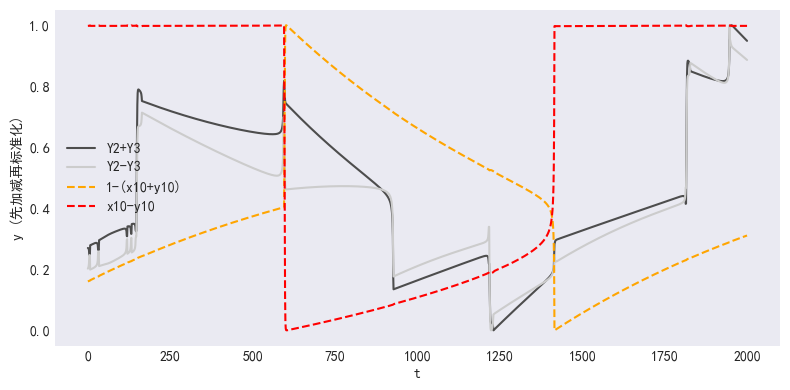

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))

sum_raw_01 = macro_data[:, 2] + macro_data[:, 3]   # Y0+Y1
dif_raw_01 = macro_data[:, 2] - macro_data[:, 3]   # Y1-Y0

sum_raw_xy = x_data[0][:, 10] + x_data[0][:, 11]     # x0+y0
dif_raw_xy = x_data[0][:, 10] - x_data[0][:, 11]     # x0-y0

def minmax(a):
    return (a - a.min()) / (a.max() - a.min())

Y0_plus_Y1 = minmax(sum_raw_01)
Y1_minus_Y0 = minmax(dif_raw_01)
x0_plus_y0 = minmax(sum_raw_xy)
x0_minus_y0 = minmax(dif_raw_xy)

ax.plot(Y0_plus_Y1, color='0.3', label='Y2+Y3')
ax.plot(Y1_minus_Y0, color='0.8', label='Y2-Y3')
ax.plot(1-x0_plus_y0, '--', color='orange', label='1-(x10+y10)')
ax.plot(x0_minus_y0, '--', color='red', label='x10-y10')

ax.legend()
ax.set(xlabel='t', ylabel='y (先加减再标准化)')
ax.grid(False)
fig.tight_layout()
plt.show()

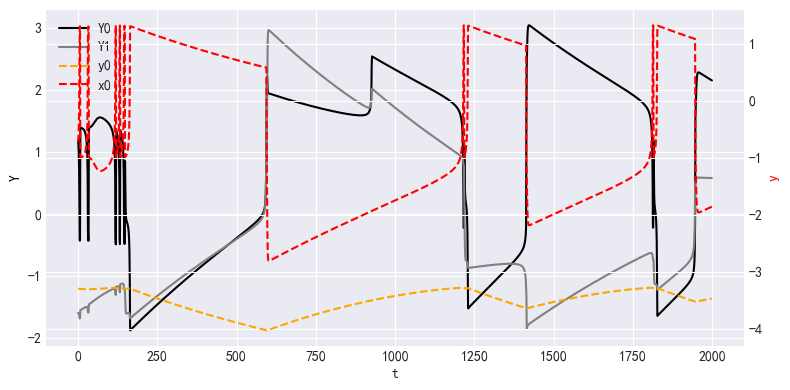

In [40]:
# 两轴
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(macro_data[:,0],color='k', label='Y0')
ax1.plot(macro_data[:,1],color='grey', label='Y1')
ax1.set_ylabel('Y', color='k')
ax1.set_xlabel('t')

ax2 = ax1.twinx()
ax2.plot(x_data[0][:,1], '--', color='orange', label='y0')
ax2.plot(x_data[0][:,0], '--', color='red', label='x0')
ax2.set_ylabel('y', color='red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

fig.tight_layout()
plt.show()

In [41]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = 1.0111 * y0[k] - 0.0000 * y1[k] + 0.0002 * y2[k] + 0.0010 * y3[k] + 0.0055 * y4[k] - 0.0002 * y5[k] + 0.0012 * y6[k] + 0.0145 * y7[k]
------------------------------
y1[k+1] = 0.0000 * y0[k] + 1.0072 * y1[k] + 0.0000 * y2[k] + 0.0001 * y3[k] + 0.0008 * y4[k] - 0.0004 * y5[k] - 0.0083 * y6[k] + 0.0008 * y7[k]
------------------------------
y2[k+1] = -0.0002 * y0[k] - 0.0000 * y1[k] + 1.0068 * y2[k] - 0.0001 * y3[k] - 0.0005 * y4[k] - 0.0080 * y5[k] + 0.0003 * y6[k] + 0.0003 * y7[k]
------------------------------
y3[k+1] = -0.0011 * y0[k] - 0.0001 * y1[k] + 0.0001 * y2[k] + 1.0003 * y3[k] - 0.0010 * y4[k] + 0.0001 * y5[k] - 0.0001 * y6[k] + 0.0021 * y7[k]
------------------------------
y4[k+1] = -0.0057 * y0[k] - 0.0008 * y1[k] + 0.0005 * y2[k] + 0.0009 * y3[k] + 0.9965 * y4[k] + 0.0002 * y5[k] - 0.0002 * y6[k] + 0.0048 * y7[k]
------------------------------
y5[k+1] = 0.0002 * y0[k] + 0.0004 * y1[k] + 0.0081 * y2[k] - 0.0001 * y3[k] - 0.0002 * y4[k] + 0.9927 * y5[k] - 0.0000 * y

# 比较不同情况下的因果力的分布形状

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import make_interp_spline
import statsmodels.api as sm
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [2]:
with open("diffCS5.pkl", "rb") as f1:
    diff1 = pickle.load(f1)
with open("diffGS5.pkl", "rb") as f2:
    diff2 = pickle.load(f2)
with open("diffQ5.pkl", "rb") as f3:
    diff3 = pickle.load(f3)
with open("diffD5.pkl", "rb") as f4:
    diff4 = pickle.load(f4)

In [ ]:
def calculate_stats(data, name):
    """
    计算单个diff的描述性统计量
    :param data: 输入的list数据
    :param name: diff的名称（用于打印）
    :return: 统计量字典
    """
    stats = {
        "名称": name,
        "长度": len(data),
        "均值": np.mean(data),
        "中位数": np.median(data),
        "最大值": np.max(data),
        "最小值": np.min(data),
        "标准差": np.std(data, ddof=1),  # 样本标准差
        "总和": np.sum(data)
    }
    return stats

In [7]:
def minmax_standard(data):
    """Min-Max 标准化 -> 结果范围 [0, 1]"""
    data_min = np.min(data)
    data_max = np.max(data)
    # 防止常数列除0
    if data_max == data_min:
        return np.zeros_like(data, dtype=float)
    data_stand = (data - data_min) / (data_max - data_min)
    return data_stand

In [8]:
stats1 = calculate_stats(diff1, "diffCS")
stats2 = calculate_stats(diff2, "diffGS")
stats3 = calculate_stats(diff3, "diffQ")
stats4 = calculate_stats(diff4, "diffD")

In [9]:
# 格式化打印单个diff的统计信息（美观对齐）
print("四个diff的描述性统计信息（单个diff分析）")
print("=" * 80)
# 定义打印格式，确保对齐
stats_format = "{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}"
# 打印表头
print(stats_format.format("名称", "长度", "均值", "中位数", "最大值", "最小值", "标准差", "总和"))
print("-" * 80)
# 打印每个diff的统计值（保留2位小数，更清晰）
for stats in [stats1, stats2, stats3, stats4]:
    print(stats_format.format(
        stats["名称"],
        stats["长度"],
        f"{stats['均值']:.2f}",
        f"{stats['中位数']:.2f}",
        f"{stats['最大值']:.2f}",
        f"{stats['最小值']:.2f}",
        f"{stats['标准差']:.2f}",
        f"{stats['总和']:.2f}"
    ))

四个diff的描述性统计信息（单个diff分析）
名称         长度         均值         中位数        最大值        最小值        标准差        总和        
--------------------------------------------------------------------------------
diffCS     229        1.11       0.02       123.86     0.00       8.83       253.64    
diffGS     229        2.43       0.06       183.66     0.01       15.35      557.32    
diffQ      229        0.31       0.02       18.70      0.01       1.51       70.48     
diffD      229        1.05       0.10       25.62      0.03       3.32       240.07    


In [10]:
n = 60 
diff1 = diff1[:n] 
diff2 = diff2[:n]
diff3 = diff3[:n]
diff4 = diff4[:n]

In [11]:
diff_data = [diff1, diff2, diff3, diff4]
diff_titles = ["完全同步（EC=2.93）", "广义同步（EC=3.49）", "奇美拉态（EC=4.42）", "去同步化（EC=5.28）"]
diff_names = ["完全同步（EC=2.93）", "广义同步（EC=3.49）", "奇美拉态（EC=4.42）", "去同步化（EC=5.28）"]
diff_colors = ["red", "blue", "green", "orange"]

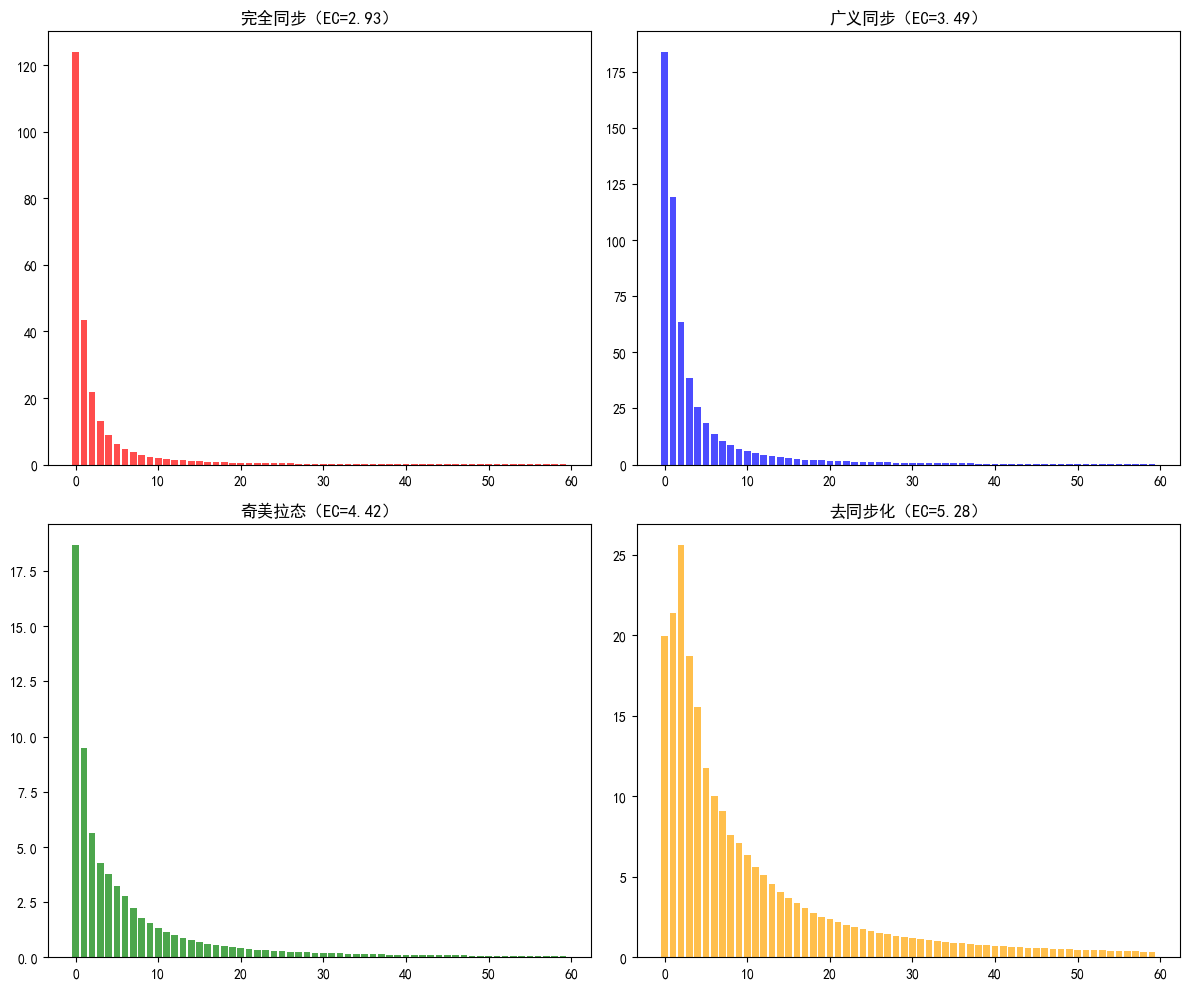

In [12]:
# 子图柱状图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # figsize设置图的大小
axes_flat = axes.flatten()

# 遍历绘制每个子图
for idx, (data, title, color, ax) in enumerate(zip(diff_data, diff_titles, diff_colors, axes_flat)):
    # 绘制柱状图：x轴为索引，y轴为diff数值
    x = range(len(data))
    ax.bar(x, data, color=color, alpha=0.7)  # alpha设置透明度，避免颜色过深
    # 设置子图标题和轴标签
    ax.set_title(title, fontsize=12, fontweight="bold")
    #ax.set_xlabel("T", fontsize=10)
    #ax.set_ylabel("数值大小", fontsize=10)
    # 设置x轴刻度（与索引对应）
    #ax.set_xticks(tick_positions)

# 调整子图之间的间距，避免重叠
plt.tight_layout()
# 显示图像
plt.show()

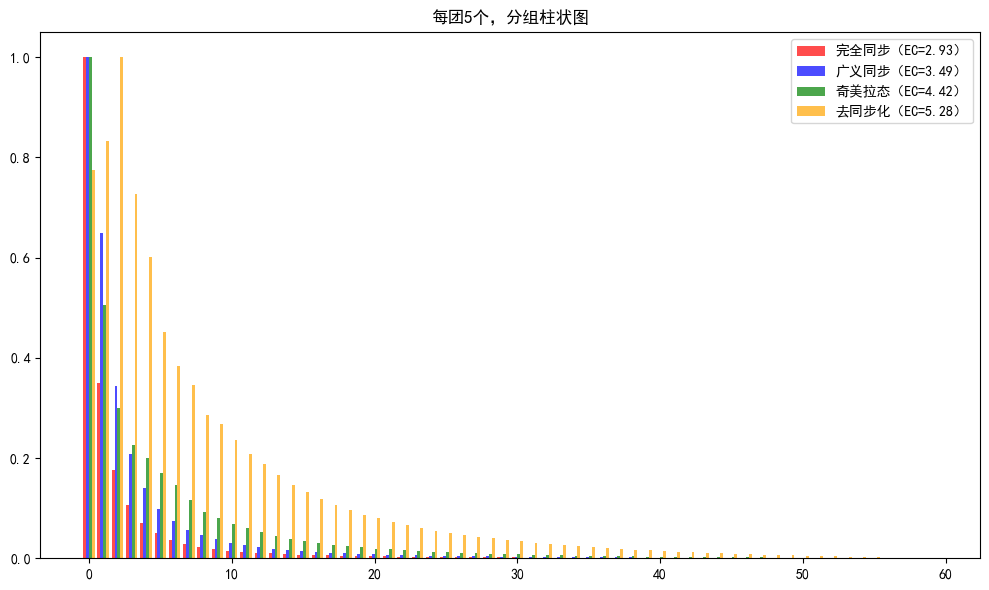

In [13]:
# 单图分组柱状图
n_pos = len(diff1)  # 索引位置数量
n_diff = 4  # diff的数量
x = np.arange(n_pos)  # 索引位置
width = 0.2  # 每个柱子的宽度（需小于1，避免重叠）
plt.figure(figsize=(10,6))
# 绘制分组柱状图：每个diff的柱子在同一索引位置并列
plt.bar(x - 1.5*width, minmax_standard(diff1), width=width, color="red", alpha=0.7, label=diff_names[0])
plt.bar(x - 0.5*width, minmax_standard(diff2), width=width, color="blue", alpha=0.7, label=diff_names[1])
plt.bar(x + 0.5*width, minmax_standard(diff3), width=width, color="green", alpha=0.7, label=diff_names[2])
plt.bar(x + 1.5*width, minmax_standard(diff4), width=width, color="orange", alpha=0.7, label=diff_names[3])

# 设置标签和标题
#plt.xlabel("索引位置", fontsize=10)
#plt.ylabel("数值大小", fontsize=10)
plt.title("每团5个，分组柱状图", fontsize=12, fontweight="bold")
#plt.xticks(tick_positions)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Administrator.DESKTOP-BFUOLPM\AppData\Local\Temp\ipykernel_5420\1682083705.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)      # 显示图例


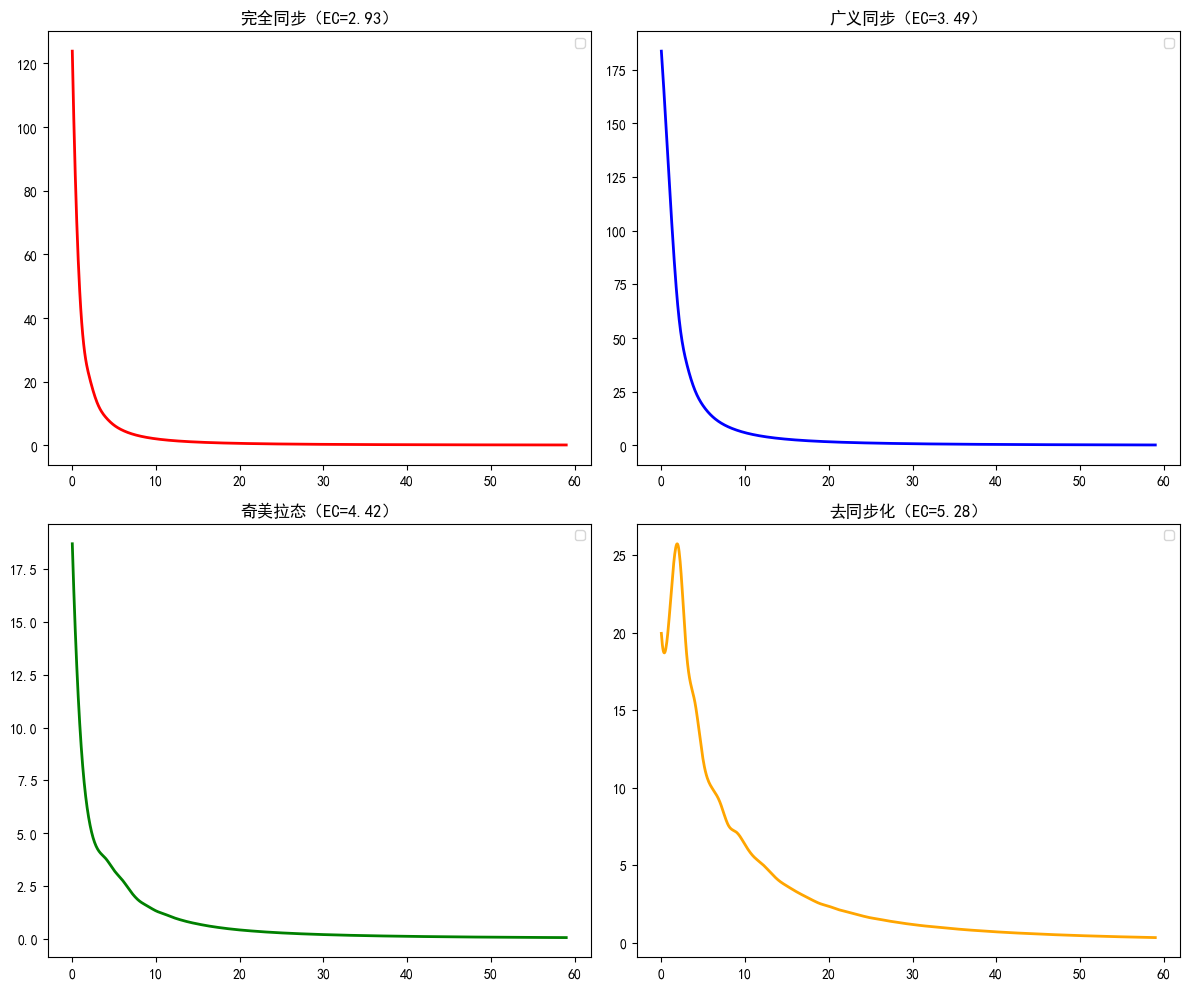

In [14]:
# 子图 插值平滑
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes_flat = axes.flatten()  # 扁平化子图数组，方便遍历

# 遍历绘制每个子图的插值平滑曲线
for idx, (data, title, color, ax) in enumerate(zip(diff_data, diff_titles, diff_colors, axes_flat)):
    # 1. 原始数据的x、y轴
    x_original = np.array(range(len(data)))  # 原始索引x
    y_original = np.array(data)              # 原始数值y

    x_smooth = np.linspace(x_original.min(), x_original.max(), 1000)

    spline = make_interp_spline(x_original, y_original)  # 生成插值函数
    y_smooth = spline(x_smooth)                          # 平滑后的y值

    ax.plot(x_smooth, y_smooth, color=color, linewidth=2)

    # 5. 设置子图属性
    ax.set_title(title, fontsize=12, fontweight="bold")
    #ax.set_xlabel("索引位置", fontsize=10)
    #ax.set_ylabel("数值大小", fontsize=10)
    #ax.set_xticks(tick_positions)  # x轴刻度对应原始索引
    ax.legend(fontsize=9)      # 显示图例

# 调整子图间距，避免重叠
plt.tight_layout()
# 显示图像
plt.show()

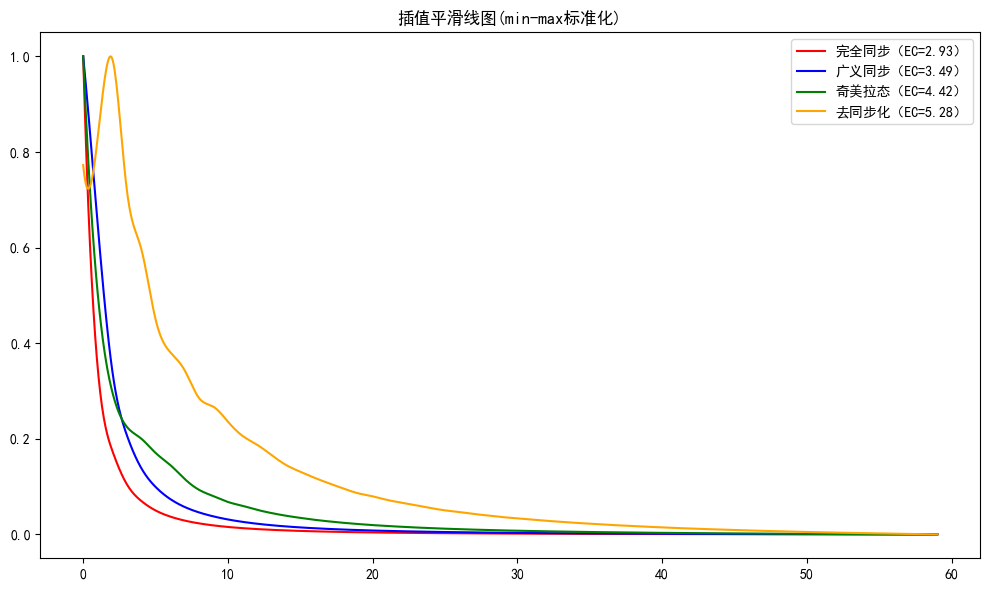

In [15]:
# 单图插值平滑
plt.figure(figsize=(10, 6))
x_original = np.array(range(len(diff1)))  # 原始x轴索引

# 创建平滑的x轴（增加x轴点数，使折线更平滑）
x_smooth = np.linspace(x_original.min(), x_original.max(), 1000) 

# 遍历绘制四条平滑折线
for data, name, color in zip(diff_data, diff_names, diff_colors):
    y_original = np.array(data)
    spline = make_interp_spline(x_original, y_original)  # 生成插值函数
    y_smooth = spline(x_smooth)  # 得到平滑后的y轴数据
    plt.plot(x_smooth, minmax_standard(y_smooth), color=color, linewidth=1.5, label=f"{name}")

# 设置标签、标题和图例
#plt.xlabel("索引位置（平滑插值）", fontsize=10)
#plt.ylabel("数值大小", fontsize=10)
plt.title("插值平滑线图(min-max标准化)", fontsize=12, fontweight="bold")
plt.legend(loc="best")
plt.tight_layout()
plt.show()